# SOM Distance


In [1]:
import sys
from types import ModuleType
from typing import Optional
from fastdtw import fastdtw

import numpy as np
from loguru import logger


class Distance:
    """ Container class for distance functions. """

    def __init__(self, xp: ModuleType = None) -> None:
        """ Instantiate the Distance class.

        Args:
            xp (numpy or cupy): the numeric labrary to use
                to calculate distances.
        """

        self.xp = xp

    def _euclidean_squared_distance_part(self, x: np.ndarray, w: np.ndarray,
                                         w_flat_sq: Optional[np.ndarray] = None) -> float:
        """ Calculate the partial squared L2 distance.

        Args:
            x (array): first array.
            w (array): second array.

        Returns:
            (float): the partial L2 squared distance between two
                provided arrays
        """

        w_flat = w.reshape(-1, w.shape[2])
        if w_flat_sq is None:
            w_flat_sq = self.xp.power(w_flat, 2).sum(axis=1, keepdims=True)
        cross_term = self.xp.dot(x, w_flat.T)
        return -2 * cross_term + w_flat_sq.T

    def _euclidean_squared_distance(self, x: np.ndarray, w: np.ndarray,
                                    w_flat_sq: Optional[np.ndarray] = None) -> float:
        """Calculate the full squared L2 distance.

        Args:
            x (array): first array.
            w (array): second array.

        Returns:
            (float): the full L2 squared distance between two
                provided arrays
        """
        x_sq = self.xp.power(x, 2).sum(axis=1, keepdims=True)
        return self._euclidean_squared_distance_part(x, w, w_flat_sq) + x_sq

    def euclidean_distance(self, x: np.ndarray, w: np.ndarray, w_flat_sq: np.ndarray) -> float:
        """Calculate the L2 distance between two arrays.

        Args:
            x(array): first array.
            w(array): second array.

        Returns:
            (float): the euclidean distance between two
                provided arrays
        """
        

        return self.xp.nan_to_num(
            self.xp.sqrt(
                self._euclidean_squared_distance(x, w, w_flat_sq)
            )
        )

    def cosine_distance(self, x: np.ndarray, w: np.ndarray, w_flat_sq: np.ndarray) -> float:
        """Calculate the cosine distance between two arrays.

        Args:
            x(array): first array.
            w(array): second array.

        Returns:
            (float): the euclidean distance between two
                provided arrays
        """

        x_sq = self.xp.power(x, 2).sum(axis=1, keepdims=True)
        x_sq = int(x_sq)
        w_flat = w.reshape(-1, w.shape[2])
        w_flat = int(w_flat)

        similarity = self.xp.nan_to_num(self.xp.dot(
            x, w_flat.T) / self.xp.sqrt(x_sq * w_flat_sq.T))

        return 1 - similarity
    
    # Define your unpadd function
    def remove_padded_values(seq, padded_value = -1):
        return [val for val in seq if val != padded_value]

    def manhattan_distance(self, x: np.ndarray, w: np.ndarray) -> float:
        """Calculate Manhattan distance between two arrays.

        Args:
            x(array): first array.
            w(array): second array.

        Returns:
            (float): the manhattan distance
                between two provided arrays.
        """

        # if self.xp.__name__ == "cupy":

        #     _manhattan_distance_kernel = self.xp.ReductionKernel(
        #         "T x, T w",
        #         "T y",
        #         "abs(x-w)",
        #         "a+b",
        #         "y = a",
        #         "0",
        #         "l1norm")

        #     d = _manhattan_distance_kernel(
        #         x[:, self.xp.newaxis, self.xp.newaxis, :],
        #         w[self.xp.newaxis, :, :, :],
        #         axis=3
        #     )

        # else:
        #     d = self.xp.linalg.norm(
        #         x[:, self.xp.newaxis, self.xp.newaxis, :] -
        #         w[self.xp.newaxis, :, :, :],
        #         ord=1,
        #         axis=3
        #     )

        # return d.reshape(x.shape[0], w.shape[0] * w.shape[1])
        return lambda point1, point2, padded_value: fastdtw(remove_padded_values(point1, padded_value),remove_padded_values(point2, padded_value))[0]
    

    def batchpairdist(self, x: np.ndarray, w: np.ndarray, sq: np.ndarray, metric: str) -> np.ndarray:
        """ Calculates distances betweens points in batches. Two array-like objects
        must be provided, distances will be calculated between all points in the
        first array and all those in the second array.

        Args:
            a(array): first array.
            b(array): second array.
            metric(string): distance metric.
                Accepted metrics are euclidean, manhattan, and cosine(default "euclidean").
        Returns:
            d(array or list): the calculated distances.
        """

        if metric == "euclidean":
            return self.euclidean_distance(x, w, sq)

        elif metric == "cosine":
            return self.cosine_distance(x, w, sq)

        elif metric == "fastdtw":
            return self.manhattan_distance(x, w)

        logger.error("Available metrics are: " +
                     "\"euclidean\", \"cosine\", \"manhattan\" and \"fastdtw\ ")
        sys.exit(1)

    def pairdist(self, a: np.ndarray, b: np.ndarray, metric: str) -> np.ndarray:
        """ Calculates distances betweens points. Two array-like objects
        must be provided, distances will be calculated between all points in the
        first array and all those in the second array.

        Args:
            a(array): first array.
            b(array): second array.
            metric(string): distance metric.
                Accepted metrics are euclidean, manhattan, and cosine(default "euclidean").

        Returns:
            d(array or list): the calculated distances.
        """

        if metric == "euclidean":
            squares_a = self.xp.sum(self.xp.power(a, 2), axis=1, keepdims=True)
            squares_b = self.xp.sum(self.xp.power(b, 2), axis=1, keepdims=True)
            return self.xp.sqrt(squares_a + squares_b.T - 2 * a.dot(b.T))

        elif metric == "cosine":
            return 1 - self.xp.dot(a / self.xp.linalg.norm(a, axis=1)[:, None],
                                   (b / self.xp.linalg.norm(b, axis=1)[:, None]).T)

        elif metric == "fastdtw":
            def func(x, y): return self.xp.sum(self.xp.abs(x.T - y), axis=-1)
            return self.xp.stack([func(a[i], b) for i in range(a.shape[0])])

        logger.error("Available metrics are: " +
                     "\"euclidean\", \"cosine\" and \"fastdtw\ ")
        sys.exit(1)


<>:167: SyntaxWarning: invalid escape sequence '\ '
<>:199: SyntaxWarning: invalid escape sequence '\ '
<>:167: SyntaxWarning: invalid escape sequence '\ '
<>:199: SyntaxWarning: invalid escape sequence '\ '
C:\Users\jessy\AppData\Local\Temp\ipykernel_16184\3487637818.py:167: SyntaxWarning: invalid escape sequence '\ '
  "\"euclidean\", \"cosine\", \"manhattan\" and \"fastdtw\ ")
C:\Users\jessy\AppData\Local\Temp\ipykernel_16184\3487637818.py:199: SyntaxWarning: invalid escape sequence '\ '
  "\"euclidean\", \"cosine\" and \"fastdtw\ ")


# SOM Early Stop

In [2]:
from copy import deepcopy
from typing import TYPE_CHECKING

from loguru import logger

if TYPE_CHECKING:
    from simpsom import SOMNet


class EarlyStop:
    """ Monitors the convergence of a map and activates
    a switch to interrupt the training if a certain tolerance
    map difference threshold is hit.

    Warning: this is a work in progress.
    Use only if you know what you are doing!
    """

    def __init__(self,
                 tolerance: float = 1e-4,
                 patience: int = 3) -> None:
        """ Initialize the early stopping class.

        Args:
            tolerance (float): the map change threshold to start
                the counter for early stopping. 
            patience (int): number of iterations with below-threshold
                map change before stopping the training.
        """

        self.tolerance = tolerance
        self.patience = patience

        self.stop_training = False
        self.convergence = []
        self.counter = 0
        self.history = None

    def calc_loss(self, net: 'SOMNet', to_monitor: str = "mapdiff") -> float:
        """ Calculate map difference convergence.

        Args:
            net (SOMNet): a SOMNet instance.
            to_monitor (str): the loss type to monitor for convergence.

        Returns:
            loss (float): the calculated loss.

        Raises:
            ValueError: if loss type is not recognized.
                Currently only map difference (mapdiff) is implemented.
        """

        all_weights = net.xp.array([n.weights for n in net.nodes_list])
        loss = None

        if self.history is not None:

            if to_monitor == "mapdiff":
                loss = net.xp.abs(net.xp.subtract(
                    all_weights, self.history)).mean()
            else:
                logger.error("Convergence method not recognized.")
                raise ValueError

        self.history = deepcopy(all_weights)

        return loss

    def check_convergence(self, loss: float) -> None:
        """ Check the change of a given loss quantity
        against its history.
        If it has been reached, activate the stop_training flag.

        Args:
            loss (float): the value to monitor.
        """

        if loss is not None:
            self.convergence.append(loss)

        if len(self.convergence) > 1 and \
                abs(self.convergence[-2] - self.convergence[-1]) < self.tolerance:
            self.counter += 1
        else:
            self.counter = 0

        if self.counter >= self.patience:
            self.stop_training = True


# SOM Neighborhoods

In [3]:
from types import ModuleType
from typing import Union, Callable, Tuple

import numpy as np
from loguru import logger
from fastdtw import fastdtw



class Neighborhoods:
    """ Container class with functions to calculate neighborhoods. """

    def __init__(self, xp: ModuleType, xx: np.ndarray, yy: np.ndarray, pbc_func: Union[Callable, None]) -> None:
        """ Instantiate the Neighborhoods class.

        Args:
            xp (numpy or cupy): the numeric labrary to use
                to calculate distances.
            xx (array): x coordinates in the grid mesh.
            yy (array): y coordinates in the grid mesh.
            pbc_function (Callable): function to extend a distance
                function to account for pbc, as defined in polygons
        """

        self.xp = xp
        self.xx = xx
        self.yy = yy
        self.pbc_func = pbc_func

    def gaussian(self, c: np.ndarray, n: np.ndarray,
                 denominator: float) -> np.ndarray:
        """ Gaussian neighborhood function.

        Args:
            c (np.ndarray): center point.
            n (np.ndarray): matrix of nodes positions.
            denominator (float): the 2sigma**2 value.

        Returns
            (np.ndarray): a matrix of distances.  
        """

        return self.xp.exp(-self.xp.power(fastdtw(n, c), 2) / denominator)

    def mexican_hat(self, c: np.ndarray, n: np.ndarray) -> np.ndarray:
        """Mexican hat neighborhood function.

        Args:
            c (np.ndarray): center point.
            n (np.ndarray): matrix of nodes positions.

        Returns
            (np.ndarray): a matrix of distances.  
        """

        return self.xp.power(n - c, 2)

    def bubble(self, c: np.ndarray, n: np.ndarray,
               threshold: float) -> np.ndarray:
        """ Bubble neighborhood function.

        Args:
            c (np.ndarray): center point.
            n (np.ndarray): matrix of nodes positions.
            threshold (float): the bubble threshold.
        Returns
            (np.ndarray): a matrix of distances.  
        """

        return self.xp.abs(n - c) < threshold

    def neighborhood_caller(self, neigh_func: str, center: Tuple[np.ndarray], sigma: float) -> np.ndarray:
        """ Returns a neighborhood selection on any 2d topology.

        Args:
            center (Tuple[np.ndarray]): index of the center point along the xx yy grid.
            sigma (float): standard deviation/size coefficient.
            nigh_func (str): neighborhood specific distance function name
                (choose among 'gaussian', 'mexican_hat' or 'bubble')

        Returns:
            (array): the resulting neighborhood matrix.
        """

        d = 2 * sigma ** 2

        nx = self.xx[self.xp.newaxis, :, :]
        ny = self.yy[self.xp.newaxis, :, :]
        cx = self.xx.T[center][:, self.xp.newaxis, self.xp.newaxis]
        cy = self.yy.T[center][:, self.xp.newaxis, self.xp.newaxis]

        if neigh_func == 'gaussian':
            shape_fun = lambda x, y: self.gaussian(x, y, denominator=d)
        elif neigh_func == 'mexican_hat':
            shape_fun = self.mexican_hat
        elif neigh_func == 'bubble':
            shape_fun = lambda x, y: self.bubble(x, y, threshold=sigma)
        else:
            logger.error("{} neighborhood function not recognized.".format(neigh_func) +
                         "Choose among 'gaussian', 'mexican_hat' or 'bubble'.")
            raise ValueError

        if self.pbc_func is not None:
            px, py = self.pbc_func((cx, cy), (nx, ny), (nx.shape[2], nx.shape[1]), shape_fun, self.xp)
        else:
            px = shape_fun(cx, nx)
            py = shape_fun(cy, ny)

        if neigh_func == 'mexican_hat':
            p = px + py
            p = self.xp.exp(-p / d) * (1 - 2 / d * p)
        else:
            p = px * py

        return p.transpose((0, 2, 1))


# SOM Polygon

In [4]:
from types import ModuleType
from typing import Union, Tuple, Callable, Collection

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
from matplotlib.figure import Figure
from matplotlib.patches import RegularPolygon


class Polygon():
    """ General class to define a custom polygonal tiling. """

    topology = None

    def get_topology(self) -> None:
        """ Get information on the set topology. """

        return self.topology

    @staticmethod
    def to_tiles(coor: Tuple[float]) -> np.ndarray:
        """ Convert 2D cartesian coordinates to tiling coordinates.

        Args:
            coor (tuple[float,..]): the Cartesian coordinates.

        Returns:
            array: a 2d array containing the coordinates in the new space.
        """

        return np.array(coor)

    @staticmethod
    def _tile(coor: Tuple[float], color: Tuple[float],
              edgecolor: Tuple[float] = None) -> type(RegularPolygon):
        """ Set the tile shape for plotting.

        Args:
            coor (tuple[float, float]): positon of the tile in the plot figure.
            color (tuple[float,...]): color tuple.
            edgecolor (tuple[float,...]): border color tuple.

        Returns:
            (matplotlib patch object): the tile to add to the plot.
        """

        return RegularPolygon(coor,
                              numVertices=4,
                              radius=.95 / np.sqrt(2),
                              orientation=np.radians(45),
                              facecolor=color,
                              edgecolor=edgecolor)

    @classmethod
    def draw_map(cls, fig: Figure, centers: Collection[float],
                 feature: Collection[float], cmap: Union[ListedColormap, None] = None) -> plt.Axes:
        """Draw a grid based on the selected tiling, nodes positions and color the tiles
        according to a given feature.

        Args:
            fig (matplotlib figure object): the figure on which the hexagonal grid will be plotted.
            centers (list, float): array containing couples of coordinates for each cell
                to be plotted in the Hexagonal tiling space.
            feature (list, float): array contaning informations on the weigths of each cell,
                to be plotted as colors.
            cmap (ListedColormap): a custom color map.

        Returns:
            ax (matplotlib axis object): the axis on which the hexagonal grid has been plotted.
        """

        ax = fig.add_subplot(111, aspect="equal")

        xpoints = [x[0] for x in centers]
        ypoints = [x[1] for x in centers]
        patches = []

        cmap = plt.get_cmap("viridis") if cmap is None else cmap
        cmap.set_bad(color="#ffffff", alpha=1.)
        edgecolor = None

        if np.isnan(feature).all():
            edgecolor = "#555555"

        for x, y, f in zip(xpoints, ypoints, feature):
            patches.append(cls._tile((x, y),
                                     color=cmap(f),
                                     edgecolor=edgecolor)
                           )

        pc = PatchCollection(patches, match_original=True, cmap=cmap)
        pc.set_array(np.array(feature))
        ax.add_collection(pc)

        ax.axis("off")
        ax.autoscale_view()

        return ax

    @staticmethod
    def distance_pbc(node_a: np.ndarray, node_b: np.ndarray, net_shape: Tuple[float],
                     distance_func: Callable, axis: Union[int, None] = None,
                     xp: ModuleType = np) -> float:
        """ Manage distances with PBC based on the tiling.

        Args:
            node_a (np.ndarray): the first node
                from which the distance will be calculated.
            node_b (np.ndarray): the second node
                from which the distance will be calculated.
            net_shape (tuple[float, float]): the sizes of
                the network.
            distance_func (function): the function
                to calculate distance between nodes.
            axis (int): axis along which the minimum
                distance across PBC will be calculated.
            xp (numpy or cupy): the numeric library
                to handle arrays.

        Returns:
            (float): the distance adjusted by PBC.
        """

        net_shape = xp.array((net_shape[0], net_shape[1]))

        return xp.min(xp.array((distance_func(node_a, node_b),
                                distance_func(node_a, node_b +
                                              net_shape * xp.array((1, 0))),
                                distance_func(node_a, node_b -
                                              net_shape * xp.array((1, 0))),
                                distance_func(node_a, node_b +
                                              net_shape * xp.array((0, 1))),
                                distance_func(node_a, node_b -
                                              net_shape * xp.array((0, 1))),
                                distance_func(node_a, node_b + net_shape),
                                distance_func(node_a, node_b - net_shape),
                                distance_func(node_a, node_b +
                                              net_shape * xp.array((-1, 1))),
                                distance_func(node_a, node_b - net_shape * xp.array((-1, 1))))), axis=0)

    @staticmethod
    def neighborhood_pbc(center_node: Tuple[np.ndarray], nodes: Tuple[np.ndarray],
                         net_shape: Tuple[float], distance_func: Callable,
                         xp: ModuleType = np) -> np.ndarray:
        """ Manage neighborhood with PBC based on the tiling, adapted for
        batch training neighborhood functions. Works along a single
        provided axis and calculates the distance of a single node (center_node) from
        all other nodes in the network (nodes)

        Args:
            center_node (Tuple[np.ndarray]): position (index) of the first node along
                the provided axis. Shaped as (net_shape[1], 1, 1), for each axis.
            nodes (Tuple[np.ndarray]): the position of all nodes
                long a given axis as a matrix.
                Shaped as (1, net_shape[1], net_shape[0]), for each axis.
            net_shape (tuple[float, float]): the sizes of
                the network.
            distance_func (function): the function
                to calculate distance between nodes.

            xp (numpy or cupy): the numeric library
                to handle arrays.

        Returns:
            (np.ndarray): the distance from all nodes adjusted by PBC.
        """

        net_shape = (xp.full(nodes[0].shape, fill_value=net_shape[0]),
                     xp.full(nodes[1].shape, fill_value=net_shape[1]))

        return xp.max(xp.array((distance_func(center_node[0], nodes[0]),
                                distance_func(
                                    center_node[0], nodes[0] + net_shape[0]),
                                distance_func(center_node[0], nodes[0] - net_shape[0]))), axis=0), \
               xp.max(xp.array((distance_func(center_node[1], nodes[1]),
                                distance_func(
                                    center_node[1], nodes[1] + net_shape[1]),
                                distance_func(center_node[1], nodes[1] - net_shape[1]))), axis=0)


class Squares(Polygon):
    """ Class to define a square tiling. """

    topology = "square"


class Hexagons(Polygon):
    """ Class to define a hexagonal tiling. """

    topology = "hexagonal"

    @staticmethod
    def to_tiles(coor: Tuple[float]) -> np.ndarray:
        """Convert 2D cartesian coordinates to tiling coordinates.

        Args:
            coor (tuple[float,..]): the Cartesian coordinates.

        Returns:
            array: a 2d array containing the coordinates in the new space.
        """

        newy = coor[1] * 2 / np.sqrt(3) * 3 / 4
        newx = coor[0]

        if coor[1] % 2:
            newx += 0.5

        return np.array((newx, newy), dtype=np.float32)

    @staticmethod
    def _tile(coor: Tuple[float], color: Tuple[float],
              edgecolor: Tuple[float] = None) -> type(RegularPolygon):
        """ Set the hexagonal tile for plotting.

        Args:
            coor (tuple[float, float]): positon of the tile in the plot figure.
            color (tuple[float,...]): color tuple.
            edgecolor (tuple[float,...]): border color tuple.

        Returns:
            (matplotlib patch object): the tile to add to the plot.
        """

        return RegularPolygon(coor,
                              numVertices=6,
                              radius=.95 / np.sqrt(3),
                              orientation=np.radians(0),
                              facecolor=color,
                              edgecolor=edgecolor)

    @staticmethod
    def distance_pbc(node_a: np.ndarray, node_b: np.ndarray, net_shape: Tuple[float],
                     distance_func: Callable, axis: Union[int, None] = None,
                     xp: ModuleType = np, ) -> float:
        """ Manage distances with PBC based on the tiling.

        Args:
            node_a (np.ndarray): the first node
                from which the distance will be calculated.
            node_b (np.ndarray): the second node
                from which the distance will be calculated.
            net_shape (tuple[float, float]): the sizes of
                the network.
            distance_func (function): the function
                to calculate distance between nodes.
            axis (int): axis along which the minimum
                distance across PBC will be calculated.
            xp (numpy or cupy): the numeric library
                to handle arrays.

        Returns:
            (float): the distance adjusted by PBC.
        """

        offset = 0 if net_shape[1] % 2 == 0 else 0.5
        offset = xp.array((offset, 0))
        net_shape = xp.array((net_shape[0], net_shape[1] * 2 / np.sqrt(3) * 3 / 4))

        return xp.min(xp.array((distance_func(node_a, node_b),
                                distance_func(node_a, node_b +
                                              net_shape * xp.array((1, 0))),
                                distance_func(node_a, node_b -
                                              net_shape * xp.array((1, 0))),
                                distance_func(
                                    node_a, node_b + net_shape * xp.array((0, 1)) + offset),
                                distance_func(
                                    node_a, node_b - net_shape * xp.array((0, 1)) - offset),
                                distance_func(node_a, node_b + net_shape + offset),
                                distance_func(node_a, node_b - net_shape - offset),
                                distance_func(
                                    node_a, node_b + net_shape * xp.array((-1, 1)) + offset),
                                distance_func(node_a, node_b - net_shape * xp.array((-1, 1)) - offset))), axis=axis)

    @staticmethod
    def neighborhood_pbc(center_node: Tuple[np.ndarray], nodes: Tuple[np.ndarray],
                         net_shape: Tuple[float], distance_func: Callable,
                         xp: ModuleType = np) -> np.ndarray:
        """ Manage neighborhood with PBC based on the tiling, adapted for
        batch training neighborhood functions. Works along a single
        provided axis and calculates the distance of a single node (center_node) from
        all other nodes in the network (nodes)

        Args:
            center_node (Tuple[np.ndarray]): position (index) of the first node along
                the provided axis. Shaped as (net_shape[1], 1, 1), for each axis.
            nodes (Tuple[np.ndarray]): the position of all nodes
                long a given axis as a matrix.
                Shaped as (1, net_shape[1], net_shape[0]), for each axis.
            net_shape (tuple[float, float]): the sizes of
                the network.
            distance_func (function): the function
                to calculate distance between nodes.
            xp (numpy or cupy): the numeric library
                to handle arrays.

        Returns:
            (np.ndarray): the distance from all nodes adjusted by PBC.
        """

        offset = xp.full(nodes[0].shape, fill_value=0)
        if net_shape[1] % 2 != 0:
            offset[:] = 0.5

        net_shape = (xp.full(nodes[0].shape, fill_value=net_shape[0]),
                     xp.full(nodes[1].shape, fill_value=net_shape[1] * 2 / xp.sqrt(3) * 3 / 4))

        return xp.max(xp.array((distance_func(center_node[0], nodes[0]),
                                distance_func(
                                    center_node[0], nodes[0] + net_shape[0] + offset),
                                distance_func(center_node[0], nodes[0] - net_shape[0] - offset))), axis=0), \
               xp.max(xp.array((distance_func(center_node[1], nodes[1]),
                                distance_func(
                                    center_node[1], nodes[1] + net_shape[1]),
                                distance_func(center_node[1], nodes[1] - net_shape[1]))), axis=0)


In [5]:
from typing import Union, Collection, Tuple

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylettes import Distinct20



def plot_map(centers: Collection[np.ndarray], feature: Collection[np.ndarray], polygons_class: Polygon,
             show: bool = True, print_out: bool = False,
             file_name: str = "./som_plot.png",
             **kwargs: Tuple[int]) -> Tuple[Figure, plt.Axes]:
    """Plot a 2D SOM

    Args:
        centers (list or array): The list of SOM nodes center point coordinates
            (e.g. node.pos)
        feature (list or array): The SOM node feature defining the color map
            (e.g. node.weights, node.diff)
        polygons_class (polygons): The polygons class carrying information on the
            map topology.
        show (bool): Choose to display the plot.
        print_out (bool): Choose to save the plot to a file.
        file_name (str): Name of the file where the plot will be saved if
            print_out is active. Must include the output path.
        kwargs (dict): Keyword arguments to format the plot:
            - figsize (tuple(int, int)): the figure size,
            - title (str): figure title,
            - cbar_label (str): colorbar label,
            - fontsize (int): font size of label, title 15% larger, ticks 15% smaller,
            - cmap (ListedColormap): a custom colormap.

    Returns:
        fig (figure object): the produced figure object.
        ax (ax object): the produced axis object.
    """

    if "figsize" not in kwargs.keys():
        kwargs["figsize"] = (5, 5)
    if "title" not in kwargs.keys():
        kwargs["title"] = "SOM"
    if "cbar_label" not in kwargs.keys():
        kwargs["cbar_label"] = "Feature value"
    if "fontsize" not in kwargs.keys():
        kwargs["fontsize"] = 12

    fig = plt.figure(figsize=(kwargs["figsize"][0], kwargs["figsize"][1]))
    ax = polygons_class.draw_map(fig, centers, feature,
                                 cmap=kwargs['cmap'] if 'cmap' in kwargs
                                 else plt.get_cmap('viridis'))
    ax.set_title(kwargs["title"], size=kwargs["fontsize"] * 1.15)

    divider = make_axes_locatable(ax)

    if not np.isnan(feature).all():
        cax = divider.append_axes("right", size="5%", pad=0.0)
        cbar = plt.colorbar(ax.collections[0], cax=cax)
        cbar.set_label(kwargs["cbar_label"], size=kwargs["fontsize"])
        cbar.ax.tick_params(labelsize=kwargs["fontsize"] * .85)
        cbar.outline.set_visible(False)

    fig.tight_layout()
    plt.sca(ax)

    if not file_name.endswith((".png", ".jpg", ".pdf")):
        file_name += ".png"

    if print_out == True:
        plt.savefig(file_name, bbox_inches="tight", dpi=300)
    if show == True:
        plt.show()

    return fig, ax


def line_plot(y_val: Union[np.ndarray, list], x_val: Union[np.ndarray, list] = None,
              show: bool = True, print_out: bool = False,
              file_name: str = "./line_plot.png",
              **kwargs: Tuple[int]) -> Tuple[Figure, plt.Axes]:
    """A simple line plot with maplotlib.

    Args: 
        y_val (array or list): values along the y axis.
        x_val (array or list): values along the x axis,
            if none, these will be inferred from the shape of y_val.
        show (bool): Choose to display the plot.
        print_out (bool): Choose to save the plot to a file.
        file_name (str): Name of the file where the plot will be saved if
            print_out is active. Must include the output path.
        kwargs (dict): Keyword arguments to format the plot:
            - figsize (tuple(int, int)): the figure size,
            - title (str): figure title,
            - xlabel (str): x-axis label,
            - ylabel (str): y-axis label,
            - logx (bool): if True set x-axis to logarithmic scale,
            - logy (bool): if True set y-axis to logarithmic scale,
            - fontsize (int): font size of label, title 15% larger, ticks 15% smaller.

    Returns:
        fig (figure object): the produced figure object.
        ax (ax object): the produced axis object.
    """

    if "figsize" not in kwargs.keys():
        kwargs["figsize"] = (5, 5)
    if "title" not in kwargs.keys():
        kwargs["title"] = "Line plot"
    if "xlabel" not in kwargs.keys():
        kwargs["xlabel"] = "x"
    if "ylabel" not in kwargs.keys():
        kwargs["ylabel"] = "y"
    if "logx" not in kwargs.keys():
        kwargs["logx"] = False
    if "logy" not in kwargs.keys():
        kwargs["logy"] = False
    if "fontsize" not in kwargs.keys():
        kwargs["fontsize"] = 12

    fig = plt.figure(figsize=(kwargs["figsize"][0], kwargs["figsize"][1]))
    ax = fig.add_subplot(111, aspect="equal")
    plt.sca(ax)
    plt.grid(False)

    if x_val is None:
        x_val = range(len(y_val))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.plot(x_val, y_val, marker="o")

    plt.xticks(fontsize=kwargs["fontsize"] * .85)
    plt.yticks(fontsize=kwargs["fontsize"] * .85)

    if kwargs["logy"]:
        ax.set_yscale("log")

    if kwargs["logx"]:
        ax.set_xscale("log")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.xlabel(kwargs["xlabel"], fontsize=kwargs["fontsize"])
    plt.ylabel(kwargs["ylabel"], fontsize=kwargs["fontsize"])

    plt.title(kwargs["title"], size=kwargs["fontsize"] * 1.15)

    ax.set_aspect("auto")
    fig.tight_layout()

    if not file_name.endswith((".png", ".jpg", ".pdf")):
        file_name += ".png"

    if print_out == True:
        plt.savefig(file_name, bbox_inches="tight", dpi=300)
    if show == True:
        plt.show()

    return fig, ax


def scatter_on_map(datagroups: Collection[np.ndarray], centers: Collection[np.ndarray],
                   polygons_class: Polygon,
                   color_val: bool = None,
                   show: bool = True, print_out: bool = False,
                   file_name: str = "./som_scatter.png",
                   **kwargs: Tuple[int]) -> Tuple[Figure, plt.Axes]:
    """Scatter plot with points projected onto a 2D SOM.

    Args:
        datagroups (list[array,...]): Coordinates of the projected points.
            This must be a nested list/array of arrays, where each element of 
            the list is a group that will be plotted separately.
        centers (list or array): The list of SOM nodes center point coordinates
            (e.g. node.pos)
        color_val (array): The feature value to use as color map, if None
                the map will be plotted as white.
        polygons_class (polygons): The polygons class carrying information on the
            map topology.
        show (bool): Choose to display the plot.
        print_out (bool): Choose to save the plot to a file.
        file_name (str): Name of the file where the plot will be saved if
            print_out is active. Must include the output path.
        kwargs (dict): Keyword arguments to format the plot:
            - figsize (tuple(int, int)): the figure size,
            - title (str): figure title,
            - cbar_label (str): colorbar label,
            - fontsize (int): font size of label, title 15% larger, ticks 15% smaller,
            - cmap (ListedColormap): a custom colormap.

    Returns:
        fig (figure object): the produced figure object.
        ax (ax object): the produced axis object.
    """

    if "figsize" not in kwargs.keys():
        kwargs["figsize"] = (5, 5)
    if "title" not in kwargs.keys():
        kwargs["title"] = "Projection onto SOM"
    if "fontsize" not in kwargs.keys():
        kwargs["fontsize"] = 12

    if color_val is None:
        color_val = np.full(len(centers), np.nan)

    fig, ax = plot_map(centers, color_val,
                       polygons_class,
                       show=False, print_out=False,
                       **kwargs)

    for i, group in enumerate(datagroups):
        print(group[:,0])
        ax.scatter(group[:, 0], group[:, 1],
                   color=Distinct20()[i % 20], edgecolor="#ffffff",
                   linewidth=1, label='{:d}'.format(i))

    plt.legend(bbox_to_anchor=(-.025, 1), fontsize=kwargs["fontsize"] * .85,
               frameon=False, title='Groups', ncol=int(len(datagroups) / 10.0) + 1,
               title_fontsize=kwargs["fontsize"])

    if not file_name.endswith((".png", ".jpg", ".pdf")):
        file_name += ".png"

    if print_out == True:
        plt.savefig(file_name, bbox_inches="tight", dpi=300)
    if show == True:
        plt.show()

    return fig, ax


# SOMNet

In [6]:
import multiprocessing
import os
import sys
import random
from functools import partial
from types import ModuleType
from typing import Union, List, Tuple

import numpy as np
from loguru import logger

class SOMNet:
    """ Kohonen SOM Network class. """

    __slots__ = ('output_path', 'cluster_algo', 'xp', 'nodes', 'data', 'metric',
                 'polygons', 'distance', 'neighborhood_fun', 'neighborhoods',
                 'convergence', 'height', 'width', 'init', 'PBC', 'GPU', 'CUML',
                 'nodes_list', 'start_sigma', 'start_learning_rate', 'epochs',
                 'tau', 'sigma', 'learning_rate')
                 
    def __init__(self, net_height: int, net_width: int, data: np.ndarray,
                 load_file: str = None, metric: str = "euclidean",
                 topology: str = "hexagonal", neighborhood_fun: str = "gaussian",
                 init: str = "random", PBC: bool = False,
                 GPU: bool = False, CUML: bool = False,
                 random_seed: int = None, debug: bool = False, output_path: str = "./") -> None:
        """ Initialize the SOM network.

        Args:
            net_height (int): Number of nodes along the first dimension.
            net_width (int): Numer of nodes along the second dimension.
            data (array): N-dimensional dataset.
            load_file (str): Name of file to load containing information
                to initialize the network weights.
            metric (string): distance metric for the identification of best matching
                units. Accepted metrics are euclidean, manhattan, and cosine (default "euclidean").
            topology (str): topology of the map tiling.
                Accepted shapes are hexagonal, and square (default "hexagonal").
            neighborhood_fun (str): neighbours drop-off function for training, choose among gaussian,
                mexican_hat and bubble (default "gaussian").
            init (str or list[array, ...]): Nodes initialization method, choose between random
                or PCA (default "random").
            PBC (boolean): Activate/deactivate periodic boundary conditions,
                warning: only quality threshold clustering algorithm works with PBC (default False).
            GPU (boolean): Activate/deactivate GPU run with RAPIDS (requires CUDA, default False).
            CUML (boolean): Use CUML for clustering. If deactivate, use scikit-learn instead
                (requires CUDA, default False).
            random_seed (int): Seed for the random numbers generator (default None).
            debug (bool): Set logging level printed to screen as debug.
            out_path (str): Path to the folder where all data and plots will be saved
                (default, current folder).
        """

        self.output_path = output_path

        # if not debug:
        #     # logger.remove()
        #     logger.add(sys.stderr, level="INFO")

        self.GPU = bool(GPU)
        self.CUML = bool(CUML)

        if self.GPU:
            try:
                import cupy
                self.xp = cupy

                if self.CUML:
                    try:
                        from cuml import cluster
                    except:
                        logger.warning(
                            "CUML libraries not found. Scikit-learn will be used instead.")

            except:
                logger.warning(
                    "CuPy libraries not found. Falling back to CPU.")
                self.GPU = False

        try:
            self.xp
        except:
            self.xp = np

        try:
            cluster
        except:
            from sklearn import cluster
        self.cluster_algo = cluster

        if random_seed is not None:
            os.environ["PYTHONHASHSEED"] = str(random_seed)
            np.random.seed(random_seed)
            random.seed(random_seed)
            self.xp.random.seed(random_seed)

        self.PBC = bool(PBC)
        if self.PBC:
            logger.info("Periodic Boundary Conditions active.")

        self.nodes_list = []
        self.data = self.xp.array(data, dtype=self.xp.float32)

        self.metric = metric

        if topology.lower() == "hexagonal":
            self.polygons = Hexagons
            logger.info("Hexagonal topology.")
        else:
            self.polygons = Squares
            logger.info("Square topology.")

        self.distance = Distance(self.xp)

        self.neighborhood_fun = neighborhood_fun.lower()
        if self.neighborhood_fun not in ['gaussian', 'mexican_hat', 'bubble']:
            logger.error("{} neighborhood function not recognized.".format(self.neighborhood_fun) +
                         "Choose among 'gaussian', 'mexican_hat' or 'bubble'.")
            raise ValueError

        self.convergence = []

        self.height = net_height
        self.width = net_width

        self.init = init
        if isinstance(self.init, str):
            self.init = self.init.lower()
        else:
            self.init = self.xp.array(self.init)
        self._set_weights(load_file)

    def _get(self, data: np.ndarray) -> np.ndarray:
        """ Moves data from GPU to CPU.
        If already on CPU, it will be left as it is.

        Args:
            data (array): data to move from GPU to CPU.

        Returns:
            (array): the same data on CPU.
        """

        if self.xp.__name__ == "cupy":
            if isinstance(data, list):
                return [d.get() for d in data]
            elif isinstance(data, np.ndarray):
                return data
            return data.get()

        return data

    def _set_weights(self, load_file: str = None) -> None:
        """ Set initial map weights values, either by loading them from file or with random/PCA.

        Args:
            load_file (str): Name of file to load containing information
                to initialize the network weights.
        """

        init_vec = None
        weights_array = None
        this_weight = None

        # When loaded from file, element 0 contains information on the network shape
        count_weight = 3

        if load_file is None:

            if isinstance(self.init, str) and self.init == "pca":
                logger.warning(
                    "Please make sure that the data have been standardized before using PCA.")
                logger.info("The weights will be initialized with PCA.")

                if self.GPU:
                    matrix = self.data.get()
                    init_vec = self.pca(matrix, n_pca=2)
                    init_vec = self.xp.array(init_vec)
                else:
                    matrix = self.data
                    init_vec = self.pca(matrix, n_pca=2)

            else:
                logger.info("The weights will be initialized randomly.")
                init_vec = [self.xp.min(self.data, axis=0),
                            self.xp.max(self.data, axis=0)]

        else:
            logger.info("The weights will be loaded from file.\n" +
                        "The map shape will be overwritten and no weights" +
                        "initialization will be applied.")
            if not load_file.endswith(".npy"):
                load_file += ".npy"
            weights_array = np.load(load_file, allow_pickle=True)
            self.height = int(weights_array[0][0])
            self.width = int(weights_array[1][0])
            self.PBC = bool(weights_array[2][0])

        for x in range(self.width):
            for y in range(self.height):

                if weights_array is not None:
                    this_weight = weights_array[count_weight]
                    count_weight += 1

                self.nodes_list.append(SOMNode(x, y, self.data.shape[1],
                                               self.height, self.width,
                                               self.PBC, self.polygons,
                                               self.xp,
                                               init_vec=init_vec,
                                               weights_array=this_weight))

    def pca(self, matrix: np.ndarray, n_pca: int) -> np.ndarray:
        """Get principal components to initialize network weights.

        Args:
            matrix (array): N-dimensional dataset.
            n_pca (int): number of components to keep.

        Returns:
            (array): Principal axes in feature space,
                representing the directions of maximum variance in the data.
        """

        mean_vector = np.mean(matrix.T, axis=1)
        center_mat = matrix - mean_vector
        cov_mat = np.cov(center_mat.T).astype(self.xp.float32)

        return np.linalg.eig(cov_mat)[-1].T[:n_pca]

    def _get_n_process(self) -> int:
        """ Count number of GPU or CPU processors.

        Returns:
            (int): the number of processors.
        """

        if self.xp.__name__ == "cupy":
            try:
                dev = self.xp.cuda.Device()
                n_smp = dev.attributes["MultiProcessorCount"]
                max_thread_per_smp = dev.attributes["MaxThreadsPerMultiProcessor"]
                return n_smp * max_thread_per_smp
            except:
                logger.error("Something went wrong when trying to count the number\n" +
                             "of GPU processors from CuPy.")
                return -1

        else:
            try:
                return multiprocessing.cpu_count()
            except:
                logger.error("Something went wrong when trying to count the number\n" +
                             "of CPU processors.")
                return -1

    def _randomize_dataset(self, data: np.ndarray, epochs: int) -> np.ndarray:
        """Generates a random list of datapoints indices for online training.

        Args:
            data (array or list): N-dimensional dataset.
            epochs (int): Number of training iterations.

        Returns:
            entries (array): array with randomized indices
        """

        if epochs < data.shape[0]:
            logger.warning(
                "Epochs for online training are less than the input datapoints.")
            epochs = data.shape[0]

        iterations = int(np.ceil(epochs / data.shape[0]))

        return [ix
                for shuffled in [np.random.permutation(data.shape[0])
                                 for it in np.arange(iterations)]
                for ix in shuffled]

    def save_map(self, file_name: str = "trained_som.npy") -> None:
        """Saves the network dimensions, the pbc and nodes weights to a file.

        Args:
            file_name (str): Name of the file where the data will be saved.
        """

        weights_array = [[float(self.height)] * self.nodes_list[0].weights.shape[0],
                         [float(self.width)] *
                         self.nodes_list[0].weights.shape[0],
                         [float(self.PBC)] * self.nodes_list[0].weights.shape[0]] + \
                        [self._get(node.weights) for node in self.nodes_list]

        if not file_name.endswith((".npy")):
            file_name += ".npy"
        logger.info("Map shape and weights will be saved to:\n" +
                    os.path.join(self.output_path, file_name))
        np.save(os.path.join(self.output_path, file_name),
                np.array(weights_array))

    def _update_sigma(self, n_iter: int) -> None:
        """Update the gaussian sigma.

        Args:
            n_iter (int): Iteration number.
        """

        self.sigma = self.start_sigma * self.xp.exp(-n_iter / self.tau)

    def _update_learning_rate(self, n_iter: int) -> None:
        """Update the learning rate.

        Args:
            n_iter (int): Iteration number.
        """

        self.learning_rate = self.start_learning_rate * \
                             self.xp.exp(-n_iter / self.epochs)

    def find_bmu_ix(self, vecs: np.array) -> 'SOMNode':
        """Find the index of the best matching unit (BMU) for a given list of vectors.

        Args:
            vec (array or list[lists, ..]): vectors whose distance from the network
                nodes will be calculated.

        Returns:
            bmu (SOMNode): The best matching unit node index.
        """

        dists = self.distance.pairdist(vecs,
                                       self.xp.array(
                                           [n.weights for n in self.nodes_list]),
                                       metric=self.metric)

        return self.xp.argmin(dists, axis=1)

    def train(self, train_algo: str = "batch", epochs: int = -1,
              start_learning_rate: float = 0.01, early_stop: str = None,
              early_stop_patience: int = 3, early_stop_tolerance: float = 1e-4, batch_size: int = -1) -> None:
        """Train the SOM.

        Args:
            train_algo (str): training algorithm, choose between "online" or "batch"
                (default "online"). Beware that the online algorithm will run one datapoint
                per epoch, while the batch algorithm runs all points at one for each epoch.
            epochs (int): Number of training iterations. If not selected (or -1)
                automatically set epochs as 10 times the number of datapoints.
                Warning: for online training each epoch corresponds to 1 sample in the
                input dataset, for batch training it corresponds to one full dataset
                training.
            start_learning_rate (float): Initial learning rate, used only in online
                learning.
            early_stop (str): Early stopping method, for now only "mapdiff" (checks if the
                weights of nodes don"t change) is available. If None, don"t use early stopping (default None).
            early_stop_patience (int): Number of iterations without improvement before stopping the
                training, only available for batch training (default 3).
            early_stop_tolerance (float): Improvement tolerance, if the map does not improve beyond
                this threshold, the early stopping counter will be activated (it needs to be set
                appropriately depending on the used distance metric). Ignored if early stopping
                is off (default 1e-4).
            batch_size (int): Split the dataset in batches of this size when calculating the
                new weights, works only when train_algo is "batch" and helps keeping down the
                memory requirements when working with large datasets, if -1 run the whole dataset
                at once.
        """

        logger.info("The map will be trained with the " +
                    train_algo + " algorithm.")
        self.start_sigma = max(self.height, self.width) / 2
        self.start_learning_rate = start_learning_rate

        self.data = self.xp.array(self.data)

        if epochs == -1:
            if train_algo == 'online':
                epochs = self.data.shape[0] * 10
            else:
                epochs = 10

        self.epochs = epochs
        self.tau = self.epochs / self.xp.log(self.start_sigma)

        if early_stop not in ["mapdiff", None]:
            logger.warning("Convergence method not recognized, early stopping will be deactivated. " +
                           "Currently only \"mapdiff\" is available.")
            early_stop = None

        if early_stop is not None:
            logger.info("Early stop active.")
            logger.warning("Early stop is an experimental feature, " +
                           "make sure to know what you are doing!")

        early_stopper = EarlyStop(tolerance=early_stop_tolerance,
                                  patience=early_stop_patience)

        if batch_size == -1 or batch_size > self.data.shape[0]:
            _n_parallel = self._get_n_process()
        else:
            _n_parallel = batch_size

        if train_algo == "online":
            """ Online training.
            Bootstrap: one datapoint is extracted randomly with replacement at each epoch
            and used to update the weights.
            """

            datapoints_ix = self._randomize_dataset(self.data, self.epochs)

            for n_iter in range(self.epochs):

                if early_stopper.stop_training:
                    logger.info(
                        "\rEarly stop tolerance reached at epoch {:d}, training will be stopped.".format(n_iter - 1))
                    self.convergence = early_stopper.convergence
                    break

                if n_iter % 10 == 0:
                    logger.debug("\rTraining SOM... {:d}%".format(
                        int(n_iter * 100.0 / self.epochs)))

                self._update_sigma(n_iter)
                self._update_learning_rate(n_iter)

                datapoint_ix = datapoints_ix.pop()
                input_vec = self.data[datapoint_ix, :].reshape(
                    1, self.data.shape[1])

                bmu = self.nodes_list[int(self.find_bmu_ix(input_vec)[0])]

                for node in self.nodes_list:
                    node._update_weights(
                        input_vec[0], self.sigma, self.learning_rate, bmu)

                if n_iter % self.data.shape[0] == 0 and early_stop is not None:
                    early_stopper.check_convergence(
                        early_stopper.calc_loss(self))

        elif train_algo == "batch":
            """ Batch training.
            All datapoints are used at once for each epoch,
            the weights are updated with the sum of contributions from all these points.
            No learning rate needed.

            Kinouchi, M. et al. "Quick Learning for Batch-Learning Self-Organizing Map" (2002).
            """

            # Storing the distances and weight matrices defeats the purpose of having
            # nodes as instances of a class, but it helps with the optimization
            # and parallelization at the cost of memory.
            # The object-oriented structure is kept to simplify code reading.

            all_weights = self.xp.array([n.weights for n in self.nodes_list], dtype=self.xp.float32)
            all_weights = all_weights.reshape(self.width, self.height, self.data.shape[1])

            numerator = self.xp.zeros(all_weights.shape, dtype=self.xp.float32)
            denominator = self.xp.zeros(
                (all_weights.shape[0], all_weights.shape[1], 1), dtype=self.xp.float32)

            unravel_precomputed = self.xp.unravel_index(self.xp.arange(self.width * self.height, dtype=self.xp.int64), (self.width, self.height))

            _xx, _yy = self.xp.meshgrid(self.xp.arange(self.width), self.xp.arange(self.height))

            if self.PBC:
                pbc_func_params = self.polygons.neighborhood_pbc
            else:
                pbc_func_params = None

            neighborhoods = Neighborhoods(self.xp, _xx, _yy, pbc_func_params)

            sq_weights = None

            for n_iter in range(self.epochs):

                if self.metric in ["euclidean", "cosine"]:
                    sq_weights = (self.xp.power(all_weights.reshape(-1, all_weights.shape[2]), 2).sum(axis=1, keepdims=True))

                if early_stopper.stop_training:
                    logger.info(
                        "\rEarly stop tolerance reached at epoch {:d}, training will be stopped.".format(n_iter - 1))
                    self.convergence = early_stopper.convergence
                    break

                self._update_sigma(n_iter)
                self._update_learning_rate(n_iter)

                if n_iter % 10 == 0:
                    logger.debug("Training SOM... {:.2f}%".format(
                        n_iter * 100.0 / self.epochs))

                try:
                    numerator.fill(0)
                    denominator.fill(0)
                except AttributeError:
                    numerator = self.xp.zeros(all_weights.shape, dtype=self.xp.float32)
                    denominator = self.xp.zeros((all_weights.shape[0], all_weights.shape[1], 1), dtype=self.xp.float32)

                for i in range(0, len(self.data), _n_parallel):
                    start = i
                    end = start + _n_parallel
                    if end > len(self.data):
                        end = len(self.data)

                    batchdata = self.data[start:end]

                    # Find BMUs for all points and subselect gaussian matrix.
                    dists = self.distance.batchpairdist(batchdata, all_weights, sq_weights, self.metric)

                    raveled_idxs = dists.argmin(axis=1)
                    wins = (unravel_precomputed[0][raveled_idxs], unravel_precomputed[1][raveled_idxs])

                    g_gpu = neighborhoods.neighborhood_caller(self.neighborhood_fun, wins, self.sigma) * self.learning_rate

                    sum_g_gpu = self.xp.sum(g_gpu, axis=0)
                    g_flat_gpu = g_gpu.reshape(g_gpu.shape[0], -1)
                    gT_dot_x_flat_gpu = self.xp.dot(g_flat_gpu.T, batchdata)

                    numerator += gT_dot_x_flat_gpu.reshape(numerator.shape)
                    denominator += sum_g_gpu[:, :, self.xp.newaxis]

                new_weights = self.xp.where(
                    denominator != 0, numerator / denominator, all_weights)

                if early_stop is not None:
                    loss = self.xp.abs(self.xp.subtract(
                        new_weights, all_weights)).mean()
                    early_stopper.check_convergence(loss)

                all_weights = new_weights

            # Revert to object oriented
            all_weights = all_weights.reshape(self.width * self.height, self.data.shape[1])
            for n_node, node in enumerate(self.nodes_list):
                node.weights = all_weights[n_node]

        else:
            logger.error(
                "Training algorithm not recognized. Choose between \"online\" and \"batch\".")
            sys.exit(1)

        if self.GPU:
            for node in self.nodes_list:
                node.weights = node.weights.get()
        if early_stop is not None:
            self.convergence = [arr.get(
            ) for arr in early_stopper.convergence] if self.GPU else early_stopper.convergence

    def get_nodes_difference(self) -> None:
        """ Extracts the neighbouring nodes difference in weights and assigns it
        to each node object.
        """

        weights = self.xp.array([node.weights for node in self.nodes_list])
        pos = self.xp.array([node.pos for node in self.nodes_list])
        weights_dist = self.distance.pairdist(
            weights, weights, metric=self.metric)

        # if self.PBC:
        # TODO: a precision issue with the PBC nodes position creates an ugly line
        # at the top and bottom of the map.
        #    pos_dist = self.polygons.distance_pbc(pos, pos,
        #        net_shape=(self.width,self.height),
        #        distance_func=lambda x, y: self.distance.pairdist(x, y, metric='euclidean'),
        #        xp=self.xp,
        #        axis=0)
        # else:
        pos_dist = self.distance.pairdist(pos, pos, metric='euclidean')

        weights_dist[(pos_dist > 1.01) | (pos_dist == 0.)] = np.nan
        [node._set_difference(value)
         for node, value in zip(self.nodes_list, self.xp.nanmean(weights_dist, axis=0))]

        logger.info('Weights difference among neighboring nodes calculated.')

    def project_onto_map(self, array: np.ndarray,
                         file_name: str = "./som_projected.npy") -> list:
        """Project the datapoints of a given array to the 2D space of the
        SOM by calculating the bmus.

        Args:
            array (array): An array containing datapoints to be mapped.
            file_name (str): Name of the file to which the data will be saved
                if not None.

        Returns:
            (list): bmu x,y position for each input array datapoint.
        """

        if not isinstance(array, self.xp.ndarray):
            array = self.xp.array(array)

        bmu_list = [
            self.nodes_list[int(mu)].pos for mu in self.find_bmu_ix(array)]

        if file_name is not None:
            if not file_name.endswith((".npy")):
                file_name += ".npy"
            logger.info("Projected coordinates will be saved to:\n" +
                        os.path.join(self.output_path, file_name))
            np.save(os.path.join(self.output_path,
                                 file_name), self._get(bmu_list))

        return self.xp.array(bmu_list)

    def cluster(self, coor: np.ndarray, project: bool = True, algorithm: str = "DBSCAN",
                file_name: str = "./som_clusters.npy", **kwargs: str) -> List[int]:
        """Project data onto the map and find clusters with scikit-learn clustering algorithms.

        Args:
            coor (array): An array containing datapoints to be mapped or
                pre-mapped if project False.
            project (bool): if True, project the points in coor onto the map.
            algorithm (clustering obj or str): The clusters identification algorithm. A scikit-like
                class can be provided (must have a fit method), or a string indicating one of the algorithms
                provided by the scikit library
            file_name (str): Name of the file to which the data will be saved
                if not None.
            kwargs (dict): Keyword arguments to the clustering algorithm:

            Returns:
            (list of int): A list containing the clusters of the input array datapoints.
        """

        bmu_coor = self.project_onto_map(coor, file_name="som_projected_" + algorithm + ".npy") \
            if project else coor
        if self.xp.__name__ == "cupy" and self.cluster_algo.__name__.startswith('sklearn'):
            bmu_coor = self._get(bmu_coor)

        if self.PBC:
            # Implementing the distance_pbc as a wrapper automatically applied to the provided metric
            # is not possible as many sklearn clustering functions don't allow for custom metric.
            logger.warning("PBC are active. Make sure to provide a PBC-compatible custom metric if possible, " +
                           "or use `polygons.distance_pbc`. See the documentation for more detail.")

        if type(algorithm) is str:

            import inspect
            modules = [module[0] for module in inspect.getmembers(
                self.cluster_algo, inspect.isclass)]

            if algorithm not in modules:
                logger.error("The desired algorithm is not among the algorithms provided by the scikit library,\n" +
                             "please provide one of the algorithms provided by the scikit library:\n" +
                             "|".join(modules))
                return None, None

            clu_algo = eval("self.cluster_algo." + algorithm)

        else:
            clu_algo = algorithm

            if not callable(getattr(clu_algo, "fit", None)):
                logger.error(
                    "There was a problem with the clustering, make sure to provide a scikit-like clustering\n" +
                    "class or use one of the algorithms provided by the scikit library,\n" +
                    "Custom classes must have a 'fit' method.")
                return None, None

        clu_algo = clu_algo(**kwargs)

        try:
            clu_labs = clu_algo.fit(bmu_coor).labels_
        except:
            logger.error("There was a problem with the clustering, make sure to provide a scikit-like clustering\n" +
                         "class or use one of the algorithms provided by the scikit library,\n" +
                         "Custom classes must have a 'fit' method.")
            return None

        if file_name is not None:
            if not file_name.endswith((".npy")):
                file_name += ".npy"
            logger.info("Clustering results will be saved to:\n" +
                        os.path.join(self.output_path, file_name))
            np.save(os.path.join(self.output_path,
                                 file_name), self._get(clu_labs))

        return clu_labs, bmu_coor

    def plot_map_by_feature(self, feature_ix: int, show: bool = False, print_out: bool = True,
                            **kwargs: Tuple[int]) -> None:
        """ Wrapper function to plot a trained 2D SOM map
        color-coded according to a given feature.

        Args:
            feature_ix (int): The feature index number to use as color map.
            show (bool): Choose to display the plot.
            print_out (bool): Choose to save the plot to a file.
            kwargs (dict): Keyword arguments to format the plot, such as 
                - figsize (tuple(int, int)), the figure size;
                - title (str), figure title;
                - cbar_label (str), colorbar label;
                - labelsize (int), font size of label, the title 15% larger, ticks 15% smaller;
                - cmap (ListedColormap), a custom cmap.
        """

        if "file_name" not in kwargs.keys():
            kwargs["file_name"] = os.path.join(self.output_path,
                                               "./som_feature_{}.png".format(str(feature_ix)))

        _, _ = plot_map([[node.pos[0], node.pos[1]] for node in self.nodes_list],
                        [node.weights[feature_ix] for node in self.nodes_list],
                        self.polygons,
                        show=show, print_out=print_out,
                        **kwargs)

        if print_out:
            logger.info("Feature map will be saved to:\n" +
                        kwargs["file_name"])

    def plot_map_by_difference(self, show: bool = False, print_out: bool = True,
                               **kwargs: Tuple[int]) -> None:
        """ Wrapper function to plot a trained 2D SOM map
        color-coded according neighbours weights difference.
        It will automatically calculate the difference values
        if not already computed.

        Args:
            show (bool): Choose to display the plot.
            print_out (bool): Choose to save the plot to a file.
            kwargs (dict): Keyword arguments to format the plot, such as
                - figsize (tuple(int, int)), the figure size;
                - title (str), figure title;
                - cbar_label (str), colorbar label;
                - labelsize (int), font size of label, the title 15% larger, ticks 15% smaller;
                - cmap (ListedColormap), a custom cmap.
        """

        if "file_name" not in kwargs.keys():
            kwargs["file_name"] = os.path.join(
                self.output_path, "./som_difference.png")

        if self.nodes_list[0].difference is None:
            self.get_nodes_difference()

        if "cbar_label" not in kwargs.keys():
            kwargs["cbar_label"] = "Nodes difference value"

        _, _ = plot_map([[node.pos[0], node.pos[1]] for node in self.nodes_list],
                        [node.difference for node in self.nodes_list],
                        self.polygons,
                        show=show, print_out=print_out,
                        **kwargs)

        if print_out:
            logger.info("Node difference map will be saved to:\n" +
                        kwargs["file_name"])

    def plot_convergence(self, show: bool = False, print_out: bool = True,
                         **kwargs: Tuple[int]) -> None:
        """ Plot the the map training progress according to the
        chosen convergence criterion, when train_algo is batch.

        Args:
            show (bool): Choose to display the plot.
            print_out (bool): Choose to save the plot to a file.
            kwargs (dict): Keyword arguments to format the plot, such as
                - figsize (tuple(int, int)), the figure size;
                - title (str), figure title;
                - xlabel (str), x-axis label;
                - ylabel (str), y-axis label;
                - logx (bool), if True set x-axis to logarithmic scale;
                - logy (bool), if True set y-axis to logarithmic scale;
                - labelsize (int), font size of label, the title 15% larger, ticks 15% smaller;
        """

        if len(self.convergence) == 0:
            logger.warning(
                "The current parameters yelded no convergence. The plot will not be produced.")

        else:

            if "file_name" not in kwargs.keys():
                kwargs["file_name"] = os.path.join(
                    self.output_path, "./som_convergence.png")

            conv_values = np.nan_to_num(self.convergence)

            if "title" not in kwargs.keys():
                kwargs["title"] = "Convergence"
            if "xlabel" not in kwargs.keys():
                kwargs["xlabel"] = "Iteration"
            if "ylabel" not in kwargs.keys():
                kwargs["ylabel"] = "Score"

            _, _ = line_plot(conv_values,
                             show=show, print_out=print_out,
                             **kwargs)

            if print_out:
                logger.info("Convergence results will be saved to:\n" +
                            kwargs["file_name"])

    def plot_projected_points(self, coor: np.ndarray, color_val: Union[np.ndarray, None] = None,
                              project: bool = True, jitter: bool = True,
                              show: bool = False, print_out: bool = True,
                              **kwargs: Tuple[int]) -> None:
        """Project points onto the trained 2D map and plot the result.

        Args:
            coor (array): An array containing datapoints to be mapped or
                pre-mapped if project False.
            color_val (array): The feature value to use as color map, if None
                the map will be plotted as white.
            project (bool): if True, project the points in coor onto the map.
            jitter (bool): if True, add jitter to points coordinates to help
                with overlapping points.
            show (bool): Choose to display the plot.
            print_out (bool): Choose to save the plot to a file.
            kwargs (dict): Keyword arguments to format the plot, such as
                - figsize (tuple(int, int)), the figure size;
                - title (str), figure title;
                - cbar_label (str), colorbar label;
                - labelsize (int), font size of label, the title 15% larger, ticks 15% smaller;
                - cmap (ListedColormap), a custom cmap.
        """

        if "file_name" not in kwargs.keys():
            kwargs["file_name"] = os.path.join(
                self.output_path, "./som_projected.png")

        bmu_coor = self.project_onto_map(coor) if project else coor
        bmu_coor = self._get(bmu_coor)

        if jitter:
            bmu_coor = np.array(bmu_coor).astype(float)
            bmu_coor += np.random.uniform(low=-.15,
                                          high=.15, size=(bmu_coor.shape[0], 2))

        _, _ = scatter_on_map([bmu_coor],
                              [[node.pos[0], node.pos[1]]
                               for node in self.nodes_list],
                              self.polygons,
                              color_val=color_val,
                              show=show, print_out=print_out,
                              **kwargs)

        if print_out:
            logger.info("Projected data scatter plot will be saved to:\n" +
                        kwargs["file_name"])

    def plot_clusters(self, coor: np.ndarray, clusters: list,
                      color_val: np.ndarray = None,
                      project: bool = False, jitter: bool = False,
                      show: bool = False, print_out: bool = True,
                      **kwargs: Tuple[int]) -> None:
        """Project points onto the trained 2D map and plot the result.

        Args:
            coor (array): An array containing datapoints to be mapped or
                pre-mapped if project False.
            clusters (list): Cluster assignment list.
            color_val (array): The feature value to use as color map, if None
                the map will be plotted as white.
            project (bool): if True, project the points in coor onto the map.
            jitter (bool): if True, add jitter to points coordinates to help
                with overlapping points.
            show (bool): Choose to display the plot.
            print_out (bool): Choose to save the plot to a file.
            kwargs (dict): Keyword arguments to format the plot, such as
                - figsize (tuple(int, int)), the figure size;
                - title (str), figure title;
                - cbar_label (str), colorbar label;
                - labelsize (int), font size of label, the title 15% larger, ticks 15% smaller;
                - cmap (ListedColormap), a custom cmap.
        """

        if "file_name" not in kwargs.keys():
            kwargs["file_name"] = os.path.join(
                self.output_path, "./som_clusters.png")

        bmu_coor = self.project_onto_map(coor) if project else coor
        bmu_coor = self._get(bmu_coor)

        if jitter:
            bmu_coor += np.random.uniform(low=-.15,
                                          high=.15, size=(bmu_coor.shape[0], 2))

        _, _ = scatter_on_map([bmu_coor[clusters == clu] for clu in set(clusters)],
                              [[node.pos[0], node.pos[1]]
                               for node in self.nodes_list],
                              self.polygons,
                              color_val=color_val,
                              show=show, print_out=print_out,
                              **kwargs)

        if print_out:
            logger.info("Clustering plot will be saved to:\n" +
                        kwargs["file_name"])


class SOMNode:
    """ Single Kohonen SOM node class. """

    __slots__ = ('xp' , 'polygons', 'PBC', 'pos', 'weights', 'difference',
                 'height', 'width')

    def __init__(self, x: int, y: int, num_weights: int, net_height: int, net_width: int,
                 PBC: bool, polygons: Polygon, xp: ModuleType = np,
                 init_vec: Union[np.ndarray, None] = None,
                 weights_array: Union[np.ndarray, None] = None) -> None:
        """Initialize the SOM node.

        Args:
            x (int): Position along the first network dimension.
            y (int): Position along the second network dimension
            num_weights (int): Length of the weights vector.
            net_height (int): Network height, needed for periodic boundary conditions (PBC)
            net_width (int): Network width, needed for periodic boundary conditions (PBC)
            PBC (bool): Activate/deactivate periodic boundary conditions.
            polygons (Polygon obj): a polygon object with information on the map topology.
            xp (numpy or cupy): the numeric library to be used.
            weight_bounds(array): boundary values for the random initialization
                of the weights. Must be in the format [min_val, max_val].
                They are overwritten by "init_vec".
            init_vec (array): Array containing the two custom vectors (e.g. PCA)
                for the weights initalization.
            weights_array (array): Array containing the weights to give
                to the node if loaded from a file.
        """

        self.xp = xp
        self.polygons = polygons
        self.PBC = PBC

        self.pos = self.xp.array(polygons.to_tiles((x, y)))

        self.weights = []
        self.difference = None

        self.height = net_height
        self.width = net_width

        if weights_array is not None:
            self.weights = weights_array

        elif init_vec is not None:
            # Sample uniformly in the space spanned by the custom vectors.
            self.weights = (init_vec[1] - init_vec[0]) * self.xp.array(
                np.random.rand(len(init_vec[0])).astype(np.float32)) + init_vec[0]

        else:
            logger.error(
                "Error in the network weights initialization, make sure to provide random initalization boundaries,\n" +
                "custom vectors, or load the weights from file.")
            sys.exit(1)

        self.weights = self.xp.array(self.weights)

    def get_node_distance(self, node: 'SOMNode') -> float:
        """ Calculate the distance within the network between the current node and second node.

        Args:
            node (SOMNode): The node from which the distance is calculated.

        Returns:
            (float): The distance between the two nodes.
        """

        if self.PBC:
            return self.polygons.distance_pbc(self.pos, node.pos,
                                              (self.width, self.height),
                                              lambda x, y: self.xp.sqrt(
                                                  self.xp.sum(self.xp.square(x - y))),
                                              xp=self.xp)
        else:
            return self.xp.sqrt(self.xp.sum(self.xp.square(self.pos - node.pos)))

    def _update_weights(self, input_vec: np.ndarray, sigma: float, learning_rate: float, bmu: 'SOMNode') -> None:
        """ Update the node weights.

        Args:
            input_vec (array): A weights vector whose distance drives the direction of the update.
            sigma (float): The updated gaussian sigma.
            learning_rate (float): The updated learning rate.
            bmu (SOMNode): The best matching unit.
        """

        dist = self.get_node_distance(bmu)
        gauss = self.xp.exp(-dist ** 2 / (2 * sigma ** 2))

        self.weights -= gauss * learning_rate * (self.weights - input_vec)

    def _set_difference(self, diff_value: Union[float, int]) -> None:
        """ Set the neighbouring nodes weights difference.

        Args:
            diff_value (float or int), the difference value to set.
        """

        self.difference = float(diff_value)


if __name__ == "__main__":
    pass


# Loading + reading data

In [7]:
from fastdtw import fastdtw
from pyclustering.utils.metric import type_metric, distance_metric
from constants import *
import numpy as np
import os
from enum import Enum
import pandas as pd



TRAIN_FILE =os.path.join("C:/Users/jessy/Desktop/Train_Arabic_Digit.txt")

NUM_MFCC = 13
ALL_COEFFS = np.arange(0, NUM_MFCC, 1)

NUM_DIGITS = 10

NUM_TRAIN_BLOCKS = 660 * NUM_DIGITS


def load_data(filepath, coeffs=ALL_COEFFS):
    """
    :param filepath: Path for the file to read, either the TRAIN_FILE or TEST_FILE
    :return:
    Organizes the data in the input file into a list of matrices. Each matrix is the data for a spoken digit,
     where the columns are the coefficients and each row is the index of the time window
    """
    mask = convert_list_to_mask(coeffs)

    digits = []
    labels = []
    current_digit = []
    with open(filepath, 'r') as f:
        # For each block, append the items into one long list and then reshape to be (-1, 13) and append to digits
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            if line.isspace() or line == "\n":
                digits = add_digit(digits, current_digit)
                current_digit = []
            else:
                mfcc = list(map(float, line.split(' ')))
                mfcc = np.asarray(mfcc)
                mfcc_filtered = mfcc[mask]
                current_digit.append(mfcc_filtered)
        if len(current_digit):
            digits = add_digit(digits, current_digit)

    num_entries_per_digit = int(len(digits) / 10)  # Should be 660 for train, 220 for test
    for digit_value in range(NUM_DIGITS):
        for i in range(num_entries_per_digit):
            labels.append(digit_value)

    return np.asarray(digits, dtype=object), np.asarray(labels)

def get_train_data(coeffs=ALL_COEFFS):
    return load_data(TRAIN_FILE, coeffs)

def convert_list_to_mask(list_of_indices):
    mask = [False] * NUM_MFCC
    for index in list_of_indices:
        assert (0 <= index < NUM_MFCC)
        mask[index] = True
    return mask


def add_digit(digits, current_digit):
    """
    :param digits: List of digits, which are each a numpy array
    :param current_digit: Current digit, which is a list of the coefficients for the digit
    :return:
    Formats and reshapes the current_digit list as a numpy array and appends it to digits and returns digits
    """
    digit_matrix = np.asarray(current_digit)
    digit_matrix = np.reshape(digit_matrix, (-1, len(current_digit[0])))
    digits.append(digit_matrix)
    return digits


In [8]:
train_data, train_labels = get_train_data()

In [9]:
print(train_data.shape)

(6600,)


In [10]:

true_labels = np.repeat(np.arange(10), 20)  
points_per_class = 20
selected_indices = []

for class_label in np.unique(true_labels):
    indices_for_class = np.where(train_labels == class_label)[0]
    selected_indices.extend(indices_for_class[:points_per_class])

print(selected_indices)
selected_data = train_data[selected_indices]
print(true_labels)
print(selected_data.shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5

# Simple SOM clustering

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

print("selected data shape:" , selected_data.shape)
padded_data = pad_sequences(selected_data, padding = 'post',value=-1, dtype=object)
print("padded data shape:" ,padded_data.shape)
num_sequences, max_length, num_features = padded_data.shape

reshaped_data = padded_data.reshape(num_sequences, -1)  

print("reshaped data shape:" ,reshaped_data.shape)

def remove_padded_values(seq, padded_value = -1):
    return [val for val in seq if val != padded_value]

user_function = lambda point1, point2: fastdtw(remove_padded_values(point1, -1), remove_padded_values(point2, -1))[0]

metric1 = distance_metric(type_metric.USER_DEFINED, func=user_function)


net = SOMNet(10, 10, reshaped_data,
                         topology='hexagonal', PBC=False,
                         init='random', metric="fastdtw",
                         random_seed=32, debug=False,
                       neighborhood_fun="gaussian" )

selected data shape: (200,)
padded data shape: (200, 49, 13)
reshaped data shape: (200, 637)


In [12]:
net.train(train_algo='online', start_learning_rate=0.01, batch_size=-1, early_stop=None)


In [13]:
cluster_labels, _ = net.cluster(reshaped_data, algorithm='KMeans', n_clusters= 10)

print(cluster_labels)

[2 2 5 2 2 2 5 0 2 2 4 2 4 4 4 4 4 4 4 4 3 3 3 7 7 3 7 3 3 3 3 3 3 3 3 3 3
 3 7 3 1 9 9 9 9 9 9 9 9 9 1 1 1 1 1 1 1 1 1 1 7 7 1 7 7 7 1 7 7 7 3 7 7 7
 7 3 3 7 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 2 2 5 5 2 2 2 5 6 3 6 0 3 0 3 3
 3 2 0 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 8 8 7 8 8 8 8 8 8 8 8 8 6 6 6 6 6
 6 6 6 0 6 6 6 6 6 6 6 6 6 6 6]


In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score

silhouette = silhouette_score(reshaped_data, cluster_labels)

davies_bouldin = davies_bouldin_score(reshaped_data, cluster_labels)

v_measure = v_measure_score(true_labels, cluster_labels)  

print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("V-Measure:", v_measure)

Silhouette Score: 0.17298046058585967
Davies-Bouldin Index: 1.8927858261704131
V-Measure: 0.7587549068602332


In [15]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score

silhouette = silhouette_score(reshaped_data, cluster_labels)
davies_bouldin = davies_bouldin_score(reshaped_data, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)

results_df = pd.DataFrame({
    'Method': ['SOM'],
    'Silhouette Score': [silhouette],
    'Davies-Bouldin Index': [davies_bouldin],
    'V-Measure': [v_measure]
})

print(results_df)

from IPython.display import display, HTML
import pandas as pd

scores = pd.DataFrame(columns=['Clustering Method', 'Silhouette Score', 'Davies-Bouldin Score', 'V-Measure'])

scores.loc[0] = ['SOM', silhouette , davies_bouldin,  v_measure]

display(HTML(scores.to_html(index=False)))



  Method  Silhouette Score  Davies-Bouldin Index  V-Measure
0    SOM           0.17298              1.892786   0.758755


Clustering Method,Silhouette Score,Davies-Bouldin Score,V-Measure
SOM,0.17298,1.892786,0.758755


# SOM with DCT 

In [16]:
# Zigzag scan of a matrix
# Argument is a two-dimensional matrix of any size,
# not strictly a square one.
# Function returns a 1-by-(m*n) array,
# where m and n are sizes of an input matrix,
# consisting of its items scanned by a zigzag method.
#
# Matlab Code:
# Alexey S. Sokolov a.k.a. nICKEL, Moscow, Russia
# June 2007
# alex.nickel@gmail.com

import numpy as np

def zigzag(input):
    #initializing the variables
    #----------------------------------
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]
    
    #print(vmax ,hmax)

    i = 0

    output = np.zeros(( vmax * hmax))
    #----------------------------------
    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:   # going up
            if (v == vmin):
            	#print(1)
                output[i] = input[v, h]   # if we got to the first line
                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        
                i = i + 1
            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
            	#print(2)
            	output[i] = input[v, h] 
            	v = v + 1
            	i = i + 1
            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
            	#print(3)
            	output[i] = input[v, h] 
            	v = v - 1
            	h = h + 1
            	i = i + 1
        else:                                    # going down
        	if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
        		#print(4)
        		output[i] = input[v, h] 
        		h = h + 1
        		i = i + 1
        	elif (h == hmin):                  # if we got to the first column
        		#print(5)
        		output[i] = input[v, h] 
        		if (v == vmax -1):
        			h = h + 1
        		else:
        			v = v + 1
        		i = i + 1
        	elif ((v < vmax -1) and (h > hmin)):     # all other cases
        		#print(6)
        		output[i] = input[v, h] 
        		v = v + 1
        		h = h - 1
        		i = i + 1
        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
        	#print(7)        	
        	output[i] = input[v, h] 
        	break
    #print ('v:',v,', h:',h,', i:',i)
    return output




# Inverse zigzag scan of a matrix
# Arguments are: a 1-by-m*n array, 
# where m & n are vertical & horizontal sizes of an output matrix.
# Function returns a two-dimensional matrix of defined sizes,
# consisting of input array items gathered by a zigzag method.
#
# Matlab Code:
# Alexey S. Sokolov a.k.a. nICKEL, Moscow, Russia
# June 2007
# alex.nickel@gmail.com


def inverse_zigzag(input, vmax, hmax):
	
	#print input.shape

	# initializing the variables
	#----------------------------------
	h = 0
	v = 0

	vmin = 0
	hmin = 0

	output = np.zeros((vmax, hmax))

	i = 0
    #----------------------------------

	while ((v < vmax) and (h < hmax)): 
		#print ('v:',v,', h:',h,', i:',i)   	
		if ((h + v) % 2) == 0:                 # going up
            
			if (v == vmin):
				#print(1)
				
				output[v, h] = input[i]        # if we got to the first line

				if (h == hmax):
					v = v + 1
				else:
					h = h + 1                        

				i = i + 1

			elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
				#print(2)
				output[v, h] = input[i] 
				v = v + 1
				i = i + 1

			elif ((v > vmin) and (h < hmax -1 )):    # all other cases
				#print(3)
				output[v, h] = input[i] 
				v = v - 1
				h = h + 1
				i = i + 1
		else:                                    # going down
			if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
				#print(4)
				output[v, h] = input[i] 
				h = h + 1
				i = i + 1
			elif (h == hmin):                  # if we got to the first column
				#print(5)
				output[v, h] = input[i] 
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1		
			elif((v < vmax -1) and (h > hmin)):     # all other cases
				output[v, h] = input[i] 
				v = v + 1
				h = h - 1
				i = i + 1
		if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
			#print(7)        	
			output[v, h] = input[i] 
			break


	return output


In [17]:
from scipy.fftpack import dctn
import matplotlib.pyplot as plt

In [18]:
dct_results = [dctn(series, type=2, norm='ortho') for series in selected_data]

zigzag_results = []
for dct_result in dct_results:
    height, width = dct_result.shape[-2:]
    zigzag_result = zigzag(dct_result)
    zigzag_results.append(zigzag_result)

min_length = min(len(zigzag_result) for zigzag_result in zigzag_results)

truncated_results = [zigzag_result[:min_length] for zigzag_result in zigzag_results]
print(truncated_results)


[array([-6.28782093e+00, -3.02279822e+00,  1.69355129e+00, -6.22025558e-01,
       -5.19900779e+00,  2.15120584e+00,  2.83812967e+00, -5.11825565e+00,
       -2.83373273e+00,  1.08570423e-01,  7.89348698e-01, -3.99131647e+00,
       -4.57829910e+00, -2.78014377e+00, -1.37825744e-01,  2.84952028e+00,
        7.24243143e-01, -3.31932648e+00, -3.48084738e+00, -2.45122523e+00,
       -4.65555197e-01,  4.71130825e-01,  4.05823522e+00, -3.90738486e+00,
       -1.03212129e+00, -1.16083860e+00,  1.03364532e+00,  1.01613665e+01,
        1.35579729e+01, -2.72537636e-01, -4.67606879e-01,  1.67946661e+00,
       -4.75139851e+00,  5.64522507e+00,  1.76080151e+00, -3.32112561e-01,
        7.42014269e-01, -1.38883470e+00,  2.17499663e+00,  2.78112435e+00,
       -3.39649714e+00,  1.45051181e+00, -3.19143981e-01,  4.71297133e+00,
        1.23015971e+01,  1.32463515e+01,  5.67626559e+00, -3.35691221e+00,
        1.37458116e+00, -2.06163887e+00,  8.42469066e-03,  4.07724547e-01,
       -1.47614392e+00, 

In [19]:
net = SOMNet(10, 10, truncated_results,
                         topology='hexagonal', PBC=False,
                         init='random', metric="euclidean",
                         random_seed=32, debug=False,
                       neighborhood_fun="gaussian" )

In [20]:
net.train(train_algo='online', start_learning_rate=0.01, batch_size=-1, early_stop=None)


In [21]:
cluster_labels, _ = net.cluster(truncated_results, algorithm='KMeans', n_clusters= 10)
print(cluster_labels)


[8 8 8 1 1 1 8 5 1 1 8 8 8 8 8 8 8 8 8 8 6 6 6 3 3 6 3 3 3 3 6 3 6 6 3 3 3
 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 7 7 5 5 5 5 5 5 5 5 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 9 9 9 4 9 4 9 9
 9 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6 6 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [22]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score

silhouette = silhouette_score(truncated_results, cluster_labels)

davies_bouldin = davies_bouldin_score(truncated_results, cluster_labels)

v_measure = v_measure_score(true_labels, cluster_labels)  

print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("V-Measure:", v_measure)

Silhouette Score: 0.24468991341732582
Davies-Bouldin Index: 1.5780688342205456
V-Measure: 0.829608116142824


In [23]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, calinski_harabasz_score
from IPython.display import HTML


silhouette = silhouette_score(truncated_results, cluster_labels)
davies_bouldin = davies_bouldin_score(truncated_results, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
calinski_harabasz_score1 = calinski_harabasz_score(truncated_results, cluster_labels)

results_df = pd.DataFrame({
    'Method': ['SOM'],
    'Silhouette Score': [silhouette],
    'Davies-Bouldin Index': [davies_bouldin],
    'Calinski Harabasz Index ' : [calinski_harabasz_score1],
    'V-Measure': [v_measure]
})

print(results_df)

scores = pd.DataFrame(columns=['Clustering Method', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski Harabasz Index', 'V-Measure'])

scores.loc[0] = ['SOM', silhouette, davies_bouldin, calinski_harabasz_score1, v_measure]

display(HTML(scores.to_html(index=False)))



  Method  Silhouette Score  Davies-Bouldin Index  Calinski Harabasz Index   \
0    SOM           0.24469              1.578069                  35.99332   

   V-Measure  
0   0.829608  


Clustering Method,Silhouette Score,Davies-Bouldin Index,Calinski Harabasz Index,V-Measure
SOM,0.24469,1.578069,35.99332,0.829608


# SOM with DCT + Feature extraction

In [24]:
import tsfel

cfg = tsfel.get_features_by_domain('temporal')
ext2 = tsfel.time_series_features_extractor(cfg, truncated_results)

*** Feature extraction started ***


C:\Users\jessy\AppData\Local\Temp\ipykernel_16184\2459330433.py:4: UserWarning: Using default sampling frequency set in configuration file.
  ext2 = tsfel.time_series_features_extractor(cfg, truncated_results)



*** Feature extraction finished ***


In [25]:
X1 = ext2.values  

net = SOMNet(20, 20, X1, metric="euclidean", neighborhood_fun='gaussian')
net.train(train_algo="online") 

In [26]:
cluster_labels1, _ = net.cluster(X1, algorithm='KMeans', n_clusters= 10)

print(cluster_labels1)

[1 3 1 3 1 1 1 3 1 3 0 9 3 4 8 4 0 0 0 0 4 4 4 7 2 4 2 4 2 4 6 8 0 7 0 0 4
 7 8 2 7 5 5 3 1 2 3 2 5 0 2 9 7 5 2 7 2 2 1 8 2 9 5 9 7 5 7 5 9 7 4 2 4 4
 8 4 2 0 0 0 4 0 3 4 7 4 6 7 8 4 0 0 6 0 6 6 0 0 0 0 5 0 1 2 1 0 1 4 2 5 3
 1 5 1 2 7 2 7 0 4 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 5 1 1 1 6 0 6 3 6 3 6 0
 0 1 1 3 6 3 3 3 6 6 3 3 0 0 0 0 7 5 4 4 0 0 4 4 0 5 4 0 0 0 9 7 0 3 2 4 3
 9 3 0 6 0 1 1 3 1 3 3 1 1 1 3]


In [27]:
cluster_labels1

array([1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 0, 9, 3, 4, 8, 4, 0, 0, 0, 0, 4, 4,
       4, 7, 2, 4, 2, 4, 2, 4, 6, 8, 0, 7, 0, 0, 4, 7, 8, 2, 7, 5, 5, 3,
       1, 2, 3, 2, 5, 0, 2, 9, 7, 5, 2, 7, 2, 2, 1, 8, 2, 9, 5, 9, 7, 5,
       7, 5, 9, 7, 4, 2, 4, 4, 8, 4, 2, 0, 0, 0, 4, 0, 3, 4, 7, 4, 6, 7,
       8, 4, 0, 0, 6, 0, 6, 6, 0, 0, 0, 0, 5, 0, 1, 2, 1, 0, 1, 4, 2, 5,
       3, 1, 5, 1, 2, 7, 2, 7, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       6, 1, 1, 1, 5, 1, 1, 1, 6, 0, 6, 3, 6, 3, 6, 0, 0, 1, 1, 3, 6, 3,
       3, 3, 6, 6, 3, 3, 0, 0, 0, 0, 7, 5, 4, 4, 0, 0, 4, 4, 0, 5, 4, 0,
       0, 0, 9, 7, 0, 3, 2, 4, 3, 9, 3, 0, 6, 0, 1, 1, 3, 1, 3, 3, 1, 1,
       1, 3])

In [28]:
v_measure = v_measure_score(true_labels, cluster_labels1)  
print("V-Measure:", v_measure)

V-Measure: 0.29429596709913


In [29]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score


silhouette = silhouette_score(X1, cluster_labels1)
davies_bouldin = davies_bouldin_score(X1, cluster_labels1)
v_measure = v_measure_score(true_labels, cluster_labels1)

results_df = pd.DataFrame({
    'Method': ['SOM'],
    'Silhouette Score': [silhouette],
    'Davies-Bouldin Index': [davies_bouldin],
    'V-Measure': [v_measure]
})

print(results_df)


scores = pd.DataFrame(columns=['Clustering Method', 'Silhouette Score', 'Davies-Bouldin Score', 'V-Measure'])

scores.loc[0] = ['SOM', silhouette, davies_bouldin, v_measure]


display(HTML(scores.to_html(index=False)))


  Method  Silhouette Score  Davies-Bouldin Index  V-Measure
0    SOM          0.101815              1.502512   0.294296


Clustering Method,Silhouette Score,Davies-Bouldin Score,V-Measure
SOM,0.101815,1.502512,0.294296


In [30]:
import pandas as pd
from sklearn.cluster import Birch, KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score



methods = ['Birch', 'KMeans']
v_measure_scores = []
davies_bouldin_scores = []
davies_bouldin_scores_scratch = []
silhouette_scores = []


n_clusters = 10
random_state = 42


for method in methods:
    if method == 'Birch':
        clustering_model = Birch(n_clusters=n_clusters, threshold=0.5)
    elif method == 'KMeans':
        clustering_model = KMeans(n_clusters=n_clusters, random_state=random_state)


    clustering_model.fit(X1)
    labels = clustering_model.labels_
    print("Cluster Labels:", labels)
    print("True Labels:", true_labels)



    silhouette_score_value = silhouette_score(X1, labels)


    davies_bouldin_score_value = davies_bouldin_score(X1, labels)

    v_measure = v_measure_score(true_labels, labels)


    silhouette_scores.append(silhouette_score_value)
    davies_bouldin_scores.append(davies_bouldin_score_value)
    v_measure_scores.append(v_measure)

Cluster Labels: [4 3 4 1 4 4 4 1 4 1 7 1 1 0 1 0 9 2 9 7 0 0 0 4 0 0 1 0 0 7 0 0 2 4 7 7 0
 1 0 0 3 4 4 1 8 0 1 0 4 9 0 3 3 4 0 3 1 1 8 1 1 1 3 3 4 4 4 4 1 3 0 1 0 0
 0 0 0 7 9 7 0 7 1 0 1 0 0 3 1 1 7 9 0 7 0 0 2 7 2 9 4 9 8 1 6 2 8 0 1 4 1
 4 3 8 1 3 1 3 2 0 4 6 5 6 6 8 5 5 5 8 5 6 0 4 4 6 4 8 8 8 0 9 7 1 7 1 0 7
 9 4 4 3 0 3 1 3 1 7 1 3 7 9 9 2 1 4 0 0 9 7 0 7 7 3 0 9 2 2 3 1 9 1 1 0 0
 3 1 9 0 7 4 4 3 8 1 3 4 4 8 3]
True Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
Cluster Labels: [1 4 1 4 1 1 1 7 5 4 6 4 7 0 7 0 6 3 6 6 0 0 0 9 7 0 7 0 7 0 0 0 3 9 0 6 0
 4 7 7 9 1 1 4 5 7 7 7 1 6 7 9 9 1 7 9 4 4 5 4 4 4 9 4 1 1 9 1 4 9

In [31]:
from IPython.display import display, HTML

scores = pd.DataFrame(columns=['Clustering Method', 'Silhouette Score', 'Davies Bouldin Score', 'V-Measure'])


for k, method in enumerate(methods):
    scores.loc[k] = [method, silhouette_scores[k], davies_bouldin_scores[k], v_measure_scores[k]]


display(HTML(scores.to_html(index=False)))

Clustering Method,Silhouette Score,Davies Bouldin Score,V-Measure
Birch,0.336349,0.786328,0.190838
KMeans,0.337379,0.839562,0.192909


# Concatenated Series

In [32]:
import numpy as np
true_labels = np.repeat((1,2,9), 3)  
print(true_labels)

points_per_class = 3
selected_indices = []

for class_label in np.unique(true_labels):
    indices_for_class = np.where(train_labels == class_label)[0]

    selected_indices.extend(indices_for_class[:points_per_class])

print(selected_indices)

[1 1 1 2 2 2 9 9 9]
[660, 661, 662, 1320, 1321, 1322, 5940, 5941, 5942]


In [33]:
import numpy as np

selected_series = [train_data[index] for index in selected_indices]

all_true_labels = []
series_lengths = []

for series, label in zip(selected_series, true_labels):
    length = len(series)
    series_lengths.append(length)
    all_true_labels.append(np.full(length, label))

concatenated_true_labels = np.concatenate(all_true_labels)
concatenated_series = np.concatenate(selected_series, axis=0)

print("Concatenated series:")
print(concatenated_series)

print("Concatenated true labels:")
print(concatenated_true_labels)



Concatenated series:
[[ 0.088296 -1.3841    1.5712   ... -0.8289   -0.2609   -0.073836]
 [ 2.3154   -0.54486   2.0853   ... -0.16291   0.055439  0.21964 ]
 [ 2.6113   -0.33944   1.8614   ... -0.19655  -0.39704   0.7933  ]
 ...
 [ 2.8999   -1.4324   -0.49144  ... -0.48261  -1.6209   -0.095764]
 [ 1.6163   -2.3476    0.34844  ... -0.43464  -1.5936    0.29967 ]
 [-0.097258 -2.6851    0.40106  ... -0.37412  -0.88393   0.11888 ]]
Concatenated true labels:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9

In [34]:
import numpy as np

selected_series = [train_data[index] for index in selected_indices]

concatenated_series = np.concatenate(selected_series, axis=0)
test = np.vstack(selected_series)

print("Concatenated series:")
print(concatenated_series)


Concatenated series:
[[ 0.088296 -1.3841    1.5712   ... -0.8289   -0.2609   -0.073836]
 [ 2.3154   -0.54486   2.0853   ... -0.16291   0.055439  0.21964 ]
 [ 2.6113   -0.33944   1.8614   ... -0.19655  -0.39704   0.7933  ]
 ...
 [ 2.8999   -1.4324   -0.49144  ... -0.48261  -1.6209   -0.095764]
 [ 1.6163   -2.3476    0.34844  ... -0.43464  -1.5936    0.29967 ]
 [-0.097258 -2.6851    0.40106  ... -0.37412  -0.88393   0.11888 ]]


# Sliding Window

In [35]:
def vectorize(data, true_labels, window_size):
    """
    Uses a sliding window to create a list of windowsize-timestep sublists for each feature.
    Returns windows along with their corresponding true labels.
    """
    num_windows = len(data) - window_size 
    windows = [data[i:i+window_size] for i in range(len(data)-window_size)]
    window_true_labels = []

    for i in range(num_windows):
        start_index = i
        end_index = i + window_size
        
        labels_in_window = true_labels[start_index:end_index]
        mode_label = np.argmax(np.bincount(labels_in_window))
        
        window_true_labels.append(mode_label)
    
    return num_windows, windows, window_true_labels


In [36]:
def calculate_centroids(windows, labels, num_clusters):
    centroids = []
    for cluster_label in range(num_clusters):
        cluster_windows = [window for window, label in zip(windows, labels) if label == cluster_label]
        if cluster_windows:
            centroid = np.mean(cluster_windows, axis=0)
            centroids.append(centroid)
    return np.array(centroids)


def sum_of_distances_within_clusters(windows, labels, centroids):
    sum_distances = np.zeros(len(labels))

    for i, window in enumerate(windows):
        centroid = centroids[labels[i]]
        distance = np.linalg.norm(window - centroid)  
        sum_distances[labels[i]] += distance

    return sum_distances

In [37]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle


def cluster_windows(windows, num_clusters, method):
    flattened_windows = np.vstack([window.reshape(-1) for window in windows])

    if method == 'KMeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
    elif method == 'DBSCAN':
        clustering = DBSCAN()
    elif method == 'Agglomerative':
        clustering = AgglomerativeClustering(n_clusters=num_clusters)
    elif method == 'Birch':
        clustering = Birch(n_clusters=num_clusters)
    
    labels = clustering.fit_predict(flattened_windows)
    centroids = calculate_centroids(windows, labels, num_clusters)


    return labels, centroids

overlap = 1
num_clusters = 3
window_sizes = [5, 10, 15, 20]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['KMeans', 'Birch']

for window_size in window_sizes:
    print(f"\n--- Window Size: {window_size} ---")
    for method in clustering_methods:
        print(f"\nClustering Method: {method}")

        num_windows, windows, window_true_labels = vectorize(concatenated_series,concatenated_true_labels, window_size)
        window_labels, centroids = cluster_windows(windows, num_clusters, method)

        silhouette = silhouette_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
        davies_bouldin = davies_bouldin_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
        ch = calinski_harabasz_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
        v_measure = v_measure_score(window_true_labels, window_labels)

        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        calinski_harabasz_scores.append(ch)
        v_measure_scores.append(v_measure)

        sum_distances = sum_of_distances_within_clusters(windows, window_labels, centroids)

        print("Sum of distances within clusters:", sum_distances[:3])
        print("Window True Labels", window_true_labels)
        print("Window Labels:", window_labels)
        print("Silhouette Score:", silhouette)
        print("Davies Bouldin Index:", davies_bouldin)
        print("Calinski Harabsz Index:", ch)
        print("V Measure:", v_measure)


--- Window Size: 5 ---

Clustering Method: KMeans
Sum of distances within clusters: [1066.28153833  818.91583157  188.63642238]
Window True Labels [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [38]:
scores = pd.DataFrame( columns=['Window Size','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in window_sizes:
    for j in clustering_methods:
        scores.loc[k] = [i, j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
        k += 1

scores

,Window Size,Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,5,KMeans,0.211947,1.651676,91.060702,0.136497
1,5,Birch,0.170030,1.897110,85.411597,0.137976
2,10,KMeans,0.219034,1.700736,60.136677,0.217894
3,10,Birch,0.135381,2.198169,59.025808,0.210333
4,15,KMeans,0.184283,1.761421,53.504136,0.177063
5,15,Birch,0.122375,2.180952,44.583572,0.165086
6,20,KMeans,0.157354,1.986936,46.746354,0.196889
7,20,Birch,0.164559,1.557403,37.834154,0.284006


# Sliding Window (SOM) (Change Number of clusters)

In [39]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from random import shuffle


def cluster_windows(windows, num_clusters, method):
    flattened_windows = np.vstack([window.reshape(-1) for window in windows])

    if method == 'SOM':
        net = SOMNet(10, 10, flattened_windows,
                         topology='hexagonal', PBC=False,
                         init='random', metric="euclidean",
                         random_seed=32, debug=False,
                       neighborhood_fun="gaussian" )

        net.train(train_algo='online', start_learning_rate=0.01, batch_size=-1, early_stop=None)


        labels, _ = net.cluster(flattened_windows, algorithm='KMeans', n_clusters= 3)

    
        centroids = calculate_centroids(windows, labels, num_clusters)
    
    return labels, centroids

overlap = 1
num_clusters = 3
window_sizes = [5, 10, 15, 20]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []

clustering_methods = ['SOM']

for window_size in window_sizes:
    print(f"\n--- Window Size: {window_size} ---")
    for method in clustering_methods:
        print(f"\nClustering Method: {method}")

        num_windows, windows, window_true_labels = vectorize(concatenated_series,concatenated_true_labels, window_size)
        window_labels, centroids = cluster_windows(windows, num_clusters, method)

        silhouette = silhouette_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
        davies_bouldin = davies_bouldin_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
        ch = calinski_harabasz_score(np.vstack([window.reshape(-1) for window in windows]), window_labels)
        v_measure = v_measure_score(window_true_labels, window_labels)

        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        calinski_harabasz_scores.append(ch)
        v_measure_scores.append(v_measure)

        sum_distances = sum_of_distances_within_clusters(windows, window_labels, centroids)

        print("Sum of distances within clusters:", sum_distances[:3])
        print("Window True Labels", window_true_labels)
        print("Window Labels:", window_labels)
        print("Silhouette Score:", silhouette)
        print("Davies Bouldin Index:", davies_bouldin)
        print("Calinski Harabsz Index:", ch)
        print("V Measure:", v_measure)



--- Window Size: 5 ---

Clustering Method: SOM
Sum of distances within clusters: [1020.91798523  854.21578827  298.01879859]
Window True Labels [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [40]:
scores = pd.DataFrame( columns=['Window Size','Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for i in window_sizes:
    for j in clustering_methods:
        scores.loc[k] = [i, j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
        k += 1

scores

,Window Size,Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,5,SOM,0.200526,2.092287,66.616249,0.183317
1,10,SOM,0.115346,2.472909,52.961343,0.172375
2,15,SOM,0.138060,2.076544,49.034769,0.127129
3,20,SOM,0.119919,2.256186,39.899714,0.066258


# Feature extraction

In [41]:
selected_data_padded = pad_sequences(selected_data, value = -1)

In [42]:
selected_data_padded_reshaped = selected_data_padded.reshape(selected_data_padded.shape[0], -1)
selected_data_padded_reshaped.shape

(200, 637)

In [43]:
import tsfel

x = list(selected_data_padded_reshaped)

cfg = tsfel.get_features_by_domain('temporal')

ext1 = tsfel.time_series_features_extractor(cfg,x)


*** Feature extraction started ***


C:\Users\jessy\AppData\Local\Temp\ipykernel_16184\781368647.py:7: UserWarning: Using default sampling frequency set in configuration file.
  ext1 = tsfel.time_series_features_extractor(cfg,x)



*** Feature extraction finished ***


In [44]:
x = list(selected_data_padded_reshaped)

cfg = tsfel.get_features_by_domain()

ext1 = tsfel.time_series_features_extractor(cfg,x)

*** Feature extraction started ***


C:\Users\jessy\AppData\Local\Temp\ipykernel_16184\65825679.py:5: UserWarning: Using default sampling frequency set in configuration file.
  ext1 = tsfel.time_series_features_extractor(cfg,x)



*** Feature extraction finished ***


In [45]:
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

corr_features = tsfel.correlated_features(ext1)
ext1.drop(corr_features, axis=1, inplace=True)

scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(ext1)


In [46]:
ext1.values

array([[1.38500000e+03, 3.93500000e+00, 1.00000000e+00, ...,
        4.88776164e-01, 2.11952057e+00, 1.99000000e+02],
       [1.09400000e+03, 3.62500000e+00, 1.00000000e+00, ...,
        4.04897909e-01, 2.10525306e+00, 1.93000000e+02],
       [1.19600000e+03, 3.20500000e+00, 1.00000000e+00, ...,
        4.01446871e-01, 2.07704970e+00, 2.21000000e+02],
       ...,
       [1.31700000e+03, 4.84500000e+00, 1.00000000e+00, ...,
        3.56702591e-01, 2.07956901e+00, 1.56000000e+02],
       [1.30100000e+03, 4.45500000e+00, 1.00000000e+00, ...,
        3.74840614e-01, 2.10187064e+00, 1.64000000e+02],
       [1.10500000e+03, 4.56500000e+00, 1.00000000e+00, ...,
        3.69756212e-01, 2.10215449e+00, 1.49000000e+02]])

In [47]:
X = ext1.values  

print("Shape of X:", X)  

net = SOMNet(20, 20, X, metric="euclidean", neighborhood_fun='gaussian')
net.train(train_algo="online")  

Shape of X: [[1.38500000e+03 3.93500000e+00 1.00000000e+00 ... 4.88776164e-01
  2.11952057e+00 1.99000000e+02]
 [1.09400000e+03 3.62500000e+00 1.00000000e+00 ... 4.04897909e-01
  2.10525306e+00 1.93000000e+02]
 [1.19600000e+03 3.20500000e+00 1.00000000e+00 ... 4.01446871e-01
  2.07704970e+00 2.21000000e+02]
 ...
 [1.31700000e+03 4.84500000e+00 1.00000000e+00 ... 3.56702591e-01
  2.07956901e+00 1.56000000e+02]
 [1.30100000e+03 4.45500000e+00 1.00000000e+00 ... 3.74840614e-01
  2.10187064e+00 1.64000000e+02]
 [1.10500000e+03 4.56500000e+00 1.00000000e+00 ... 3.69756212e-01
  2.10215449e+00 1.49000000e+02]]


In [48]:
X.shape

(200, 348)

In [49]:
true_labels = np.repeat(np.arange(10), 20)  

In [50]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score ,adjusted_rand_score, fowlkes_mallows_score, v_measure_score
from sklearn.cluster import KMeans, Birch, DBSCAN, AgglomerativeClustering
import simpsom

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
v_measure_scores = []
ari_scores = []
fmi_scores = []

clustering_methods = {
    "KMeans": KMeans(n_clusters=10),
    "Birch": Birch(n_clusters=10, threshold=0.5),
    "SOM": SOMNet(10, 10, X, metric='euclidean')
}

for method_name, method in clustering_methods.items():
    print(f"Clustering Method: {method_name}")
    
    if method_name == "SOM":
        net = SOMNet(10, 10, X, metric='euclidean')
        net.train(train_algo='online', start_learning_rate=0.01, batch_size=-1, early_stop=None)
        labels, _ = net.cluster(X, algorithm='KMeans', n_clusters= 10)
    else:
        method.fit(X)
        labels = method.labels_

    # Calculate evaluation metrics
    sil = silhouette_score(X, labels)
    davies_bouldin_score_value = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    v_measure = v_measure_score(true_labels, labels)
    ari_score = adjusted_rand_score(true_labels, labels)
    fmi_score = fowlkes_mallows_score(true_labels, labels)

    silhouette_scores.append(sil)
    davies_bouldin_scores.append(davies_bouldin_score_value)
    calinski_harabasz_scores.append(ch)
    v_measure_scores.append(v_measure)
    ari_scores.append(ari_score)
    fmi_scores.append(fmi_score)


    # Print evaluation metrics
    print("Silhouette Score: ", sil)
    print("Davies Bouldin Score: ", davies_bouldin_score_value)
    print("V-Measure: ", v_measure)
    print("Adjusted Rand Index:", ari_score)
    print("Fowlkes-Mallows Index:", fmi_score)
    print()


Clustering Method: KMeans
Silhouette Score:  0.18419655315930086
Davies Bouldin Score:  1.5228094983580738
V-Measure:  0.5132762637848909
Adjusted Rand Index: 0.29529724346816416
Fowlkes-Mallows Index: 0.3676648305239153

Clustering Method: Birch
Silhouette Score:  0.1761215517094459
Davies Bouldin Score:  1.4168397280362695
V-Measure:  0.5349348869795293
Adjusted Rand Index: 0.28425559389900845
Fowlkes-Mallows Index: 0.36353070203638405

Clustering Method: SOM
Silhouette Score:  0.10533613654162752
Davies Bouldin Score:  2.0880043365648264
V-Measure:  0.4101956046664542
Adjusted Rand Index: 0.2089569799396593
Fowlkes-Mallows Index: 0.2883221048947935



In [51]:
scores = pd.DataFrame( columns=['Clustering Method' ,'Silhouette Score', 'Davies Bouldin Index', 'Calinski Harabsz Index', 'V Measure'])
k = 0
for j in clustering_methods:
    scores.loc[k] = [j, silhouette_scores[k], davies_bouldin_scores[k], calinski_harabasz_scores[k], v_measure_scores[k]]
    k += 1

scores

,Clustering Method,Silhouette Score,Davies Bouldin Index,Calinski Harabsz Index,V Measure
0,KMeans,0.184197,1.522809,89.990721,0.513276
1,Birch,0.176122,1.416840,86.678976,0.534935
2,SOM,0.105336,2.088004,75.281526,0.410196


In [52]:
cluster_labels1, _ = net.cluster(X, algorithm='KMeans', n_clusters= 10)

print(cluster_labels1)

[2 9 2 9 9 6 9 1 1 1 6 6 2 6 2 1 1 1 1 6 4 7 0 7 0 0 0 5 7 0 1 7 0 9 1 7 1
 1 7 1 3 3 4 3 8 3 5 5 4 5 3 3 8 3 5 8 3 3 8 8 7 5 3 3 3 3 3 5 3 8 7 4 8 7
 4 0 4 7 7 7 0 0 5 5 5 5 5 5 5 0 0 4 1 0 0 0 5 0 0 4 2 1 6 1 2 1 6 1 6 1 1
 6 1 6 1 1 1 6 1 1 2 2 2 2 2 9 2 2 2 2 2 2 6 2 2 2 2 2 2 2 7 7 7 0 9 9 1 0
 7 2 2 6 6 2 1 6 6 6 6 6 5 5 5 5 5 8 5 5 5 5 4 3 5 9 9 5 5 5 8 8 9 3 4 1 9
 9 9 0 4 0 2 2 6 2 6 6 2 2 2 6]


In [53]:
X.shape

(200, 348)

In [54]:
cluster_labels1

array([2, 9, 2, 9, 9, 6, 9, 1, 1, 1, 6, 6, 2, 6, 2, 1, 1, 1, 1, 6, 4, 7,
       0, 7, 0, 0, 0, 5, 7, 0, 1, 7, 0, 9, 1, 7, 1, 1, 7, 1, 3, 3, 4, 3,
       8, 3, 5, 5, 4, 5, 3, 3, 8, 3, 5, 8, 3, 3, 8, 8, 7, 5, 3, 3, 3, 3,
       3, 5, 3, 8, 7, 4, 8, 7, 4, 0, 4, 7, 7, 7, 0, 0, 5, 5, 5, 5, 5, 5,
       5, 0, 0, 4, 1, 0, 0, 0, 5, 0, 0, 4, 2, 1, 6, 1, 2, 1, 6, 1, 6, 1,
       1, 6, 1, 6, 1, 1, 1, 6, 1, 1, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2,
       6, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 0, 9, 9, 1, 0, 7, 2, 2, 6, 6, 2,
       1, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 4, 3, 5, 9, 9, 5,
       5, 5, 8, 8, 9, 3, 4, 1, 9, 9, 9, 0, 4, 0, 2, 2, 6, 2, 6, 6, 2, 2,
       2, 6])

In [55]:
v_measure = v_measure_score(true_labels, cluster_labels1)  
print("V-Measure:", v_measure)

V-Measure: 0.4260911476053161


In [56]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import v_measure_score

birch_model = Birch(n_clusters=10, threshold=0.5)
birch_model.fit(X)
labels = birch_model.labels_

print(labels)

sil = silhouette_score(X, labels)
davies_bouldin_score_value = davies_bouldin_score(X, labels)
v_measure = v_measure_score(true_labels, labels)


print("Cluster Labels:", labels)
print("Silhouette Score: ",sil)
print("Davies Bouldin Score: ",davies_bouldin_score_value)
print("V-Measure: ",v_measure)

[2 1 2 1 1 1 1 0 1 1 1 1 2 1 2 0 0 0 0 1 5 5 5 5 5 5 5 5 5 5 0 0 5 0 0 0 0
 0 5 0 5 5 7 7 7 7 3 3 7 3 4 4 4 4 4 4 4 4 8 4 5 7 7 5 7 7 7 3 7 7 5 5 7 5
 5 5 7 7 7 7 6 6 6 6 6 6 6 6 6 6 5 5 0 6 5 5 6 5 6 5 2 0 9 0 2 0 9 0 9 9 0
 1 0 9 0 9 0 9 0 0 2 2 2 2 2 0 2 2 2 2 2 2 1 2 2 2 2 2 2 2 5 5 5 5 5 1 9 5
 5 1 1 1 1 1 9 1 9 9 1 1 3 3 3 3 3 8 3 3 3 3 0 4 4 8 8 4 3 4 8 4 5 5 0 0 0
 0 0 5 5 5 1 2 1 2 1 1 1 2 2 1]
Cluster Labels: [2 1 2 1 1 1 1 0 1 1 1 1 2 1 2 0 0 0 0 1 5 5 5 5 5 5 5 5 5 5 0 0 5 0 0 0 0
 0 5 0 5 5 7 7 7 7 3 3 7 3 4 4 4 4 4 4 4 4 8 4 5 7 7 5 7 7 7 3 7 7 5 5 7 5
 5 5 7 7 7 7 6 6 6 6 6 6 6 6 6 6 5 5 0 6 5 5 6 5 6 5 2 0 9 0 2 0 9 0 9 9 0
 1 0 9 0 9 0 9 0 0 2 2 2 2 2 0 2 2 2 2 2 2 1 2 2 2 2 2 2 2 5 5 5 5 5 1 9 5
 5 1 1 1 1 1 9 1 9 9 1 1 3 3 3 3 3 8 3 3 3 3 0 4 4 8 8 4 3 4 8 4 5 5 0 0 0
 0 0 5 5 5 1 2 1 2 1 1 1 2 2 1]
Silhouette Score:  0.1761215517094459
Davies Bouldin Score:  1.4168397280362695
V-Measure:  0.5349348869795293


# Mc2PCA (FAILED)

In [57]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
from scipy.spatial.distance import cosine
from dtw import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [58]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from fastdtw import dtw  # Assuming you are using fastdtw for DTW distance

class Mc2PCA:
    def __init__(self, K: int, p: int, epsilon: float = 1e-7, max_iter: int = 100, distance_metric: str = 'euclidean'):
        """
        Initialize Mc2PCA algorithm parameters.

        Args:
            K (int): Number of clusters.
            p (int): Number of principal components to retain in CPCA.
            epsilon (float): Convergence threshold.
            max_iter (int): Maximum number of iterations.
            distance_metric (str): Distance metric for clustering.
        """
        self.K = K
        self.p = p
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.S = None
        self.idx = None
        self.E = None
        self.info_by_cluster = None

    def fit(self, X: np.ndarray or pd.DataFrame):
        """
        Fit the model to the data.

        Args:
            X (DataFrame or ndarray): Input multivariate time series data.
        """
        if isinstance(X, pd.DataFrame):
            X = self.convert_to_numpy(X)

        X = self.center_data(X)
        cov_matrices = self.compute_covariance_matrices(X)

        idx = np.array_split(np.arange(X.shape[0]), self.K)
        S, _ = self.compute_common_spaces(cov_matrices, idx, self.p)

        E = [np.inf]

        for t in tqdm(range(1, self.max_iter + 1), leave=False):

            # Unpad the data before computations
            X_unpadded = self.unpadded_data(X)

            # Assign the clusters based on k-means
            I, v = self.assign_clusters(X_unpadded, S, self.K, distance_metric=self.distance_metric)
            E.append(np.sum(v) / len(v))  # normalize the error

            # Check convergence
            if np.abs(E[t - 1] - E[t]) < self.epsilon:
                break

            # Assign new clusters
            idx = [np.where(I == k)[0] for k in range(self.K)]

            # Compute the new common spaces after the assignment
            S, info_by_cluster = self.compute_common_spaces(cov_matrices, idx, self.p)

        # Store the results in the class attributes
        self.info_by_cluster = info_by_cluster
        self.idx = idx
        self.E = E
        self.S = S
        return idx, E, info_by_cluster

    def inference(self, X_test: np.ndarray or pd.DataFrame):
        """  
        Perform inference on the given test set using the learned model.

        Args:
            X_test (DataFrame or ndarray): The input MTS that can be stored as a DataFrame containing the data with samples as 
                        rows and variables as columns, and each cell containing a pandas Series 
                        object or a numpy ndarray, OR a 2D NumPy array with the same shape and containing
                        a 1D NumPy array in each cell.
            
        """
        if isinstance(X_test, pd.DataFrame):
            X_test = self.convert_to_numpy(X_test)  

        X_test = self.center_data(X_test)

        I, _ = self.assign_clusters(X_test, self.S, self.K, distance_metric=self.distance_metric)

        idx = [np.where(I == k)[0] for k in range(self.K)]

        return idx
    
    def save_model(self, path: str):
        """
        Save the model using pickle.

        Args:
            path (str): The path to the file where the model should be saved.
        """
        with open(path, 'wb') as file:
            pickle.dump(self, file)
        

    def load_model(cls, path: str):
        """
        Load a model using pickle.

        Args:
            path (str): The path to the file from which the model should be loaded.

        Returns:
            Mc2PCA: The loaded model.
        """
        with open(path + '.pkl', 'rb') as file:
            return pickle.load(file)

    @staticmethod
    def convert_to_numpy(df):
        """
        Convert a DataFrame where each cell contains a pandas Series into a 1D NumPy array.

        Args:
            df (DataFrame): The input DataFrame containing the data with samples as rows and variables as columns, 
                            and each cell containing a pandas Series object, or a numpy ndarray.
        
        Returns:
            ndarray: The 2D NumPy array containing the data with samples as rows and variables as columns, 
                     and each cell containing a 1D NumPy array.
        """

        # First convert the pandas series to ndarray if necessary
        if isinstance(df.iloc[0, 0], pd.Series):
            for col_name in df.columns:
                df[col_name] = df[col_name].apply(lambda series: series.to_numpy() if series is not None else np.nan)

        df_npy = df.to_numpy()

        return df_npy
    
    @staticmethod
    def center_data(X):
        """
        Center the data by subtracting the mean of each time series from each cell.

        Args:
            X (ndarray): The input 2D NumPy array containing the multivariate time series data with samples as rows and variables as columns, and each cell containing a 1D numpy ndarray.
        
        Returns:
            ndarray: The centered 2D NumPy array.
        """
        n, m = X.shape  # Number of samples and features
        centered_X = np.empty_like(X)

        for i in range(n):
            for j in range(m):
                time_series = X[i, j]
                mean = np.mean(time_series)
                centered_X[i, j] = time_series - mean

        return centered_X
    
    @staticmethod
    def compute_covariance_matrices(centered_X):
        """
        Compute the covariance matrix of each time series in the given 2D Numpy array.

        Args:
            centered_X (ndarray): The input 2D NumPy array containing the centered multivariate time series data, 
                                  where each cell contains a 1D NumPy array representing a time series.
        
        Returns:
            list: A list containing the covariance matrix of each time series in the given array.
        """
        n, m = centered_X.shape
        cov_matrices = []

        for i in range(n):
            row_data = np.column_stack([centered_X[i, j] for j in range(m) if centered_X[i, j] is not None])
            cov_matrix = np.cov(row_data.T, bias=True) if row_data.size > 0 else np.zeros((m, m))
            cov_matrices.append(cov_matrix)

        return cov_matrices
    
    @staticmethod
    def compute_common_spaces(cov_matrices, cluster_indices, p):
        """
        Compute the common principal components of each cluster using CPCA.

        Args:
            cov_matrices (list of ndarray): A list of covariance matrices for all samples in the dataset.
            cluster_indices (list of list of int): A list of K lists, each containing the indices of the samples in the kth cluster.
            p (int): The number of principal components to retain in CPCA.

        Returns:
            list of ndarray: A list of K arrays, each array containing the common space of the kth cluster.
        """
        S = []
        info_by_cluster = []
        for indices in cluster_indices:
            if len(indices) > 0:
                vec_propres, prct_info = Mc2PCA.CPCA([cov_matrices[i] for i in indices], p)
                S.append(vec_propres)
                info_by_cluster.append(prct_info)
            else:
                S.append(None)
        return S, info_by_cluster

    @staticmethod
    def CPCA(Sigma, p):
        """
        Perform Common Principal Component Analysis on a set of covariance matrices corresponding to
        a cluster of a multivariate time series, and return the common space of the cluster.

        Args:
            Sigma (list of ndarray): The list of covariance matrices.
            p (int): The number of principal components to retain.

        Returns:
            ndarray: The common space of the cluster.
        """
        mean_cov = np.mean(Sigma, axis=0) if len(Sigma) > 0 else np.zeros_like(Sigma[0])
        _, val_propre, vt = np.linalg.svd(mean_cov)
        val_propre = val_propre ** 2
        prct_info = np.sum(val_propre[:p] / np.sum(val_propre))
        return vt[:p, :].T, prct_info

    @staticmethod
    def remove_padded_values(seq, padded_value=-1):
        return [val for val in seq if val != padded_value]

    @staticmethod
    def assign_clusters(X, S, K, distance_metric='euclidean'):
        """
        Assign each multivariate time series to a cluster based on the reconstruction error.

        Args:
            X (ndarray): The input array containing the centered multivariate time series.
            S (list of ndarray): A list of K arrays, each array containing the common space of the kth cluster.
            K (int): The number of clusters.
            distance_metric (str, optional): The distance metric for error computation. Defaults to 'euclidean'.

        Returns:
            tuple: A tuple containing two elements:
                - ndarray: An array containing the indices of the clusters to which each time series is assigned.
                - ndarray: An array containing containing the minimum reconstruction error for each time series.
        """
        n = X.shape[0]
        Error = np.zeros((n, K))

        for k in range(K):
            if S[k] is not None:
                sst = np.matmul(S[k], S[k].T)
                for i in range(n):
                    time_series = X[i, :]  # Removed np.column_stack as it's already a 1D array
                    Y = np.matmul(time_series, sst)
                    if distance_metric == 'euclidean':
                        err = np.linalg.norm(time_series - Y, axis=1)
                    elif distance_metric == 'cosine':
                        err = np.array([cosine(time_series[j], Y[j]) for j in range(time_series.shape[0])])
                    elif distance_metric == 'dtw':
                        _, err = dtw(Mc2PCA.remove_padded_values(time_series), Mc2PCA.remove_padded_values(Y))
                    elif distance_metric == 'l1':
                        err = np.linalg.norm(time_series - Y, ord=1, axis=1)
                    Error[i, k] = np.mean(err)
            else:
                Error[:, k] = np.inf

        I = np.argmin(Error, axis=1)
        v = Error[np.arange(n), I]
        return I, v



    @staticmethod
    def unpadded_data(X):
        """
        Unpad the data by removing padded values.

        Args:
            X (ndarray): Input array with padded values.

        Returns:
            ndarray: Array with padding removed.
        """
        unpadded_data = []
        for row in X:
            unpadded_row = Mc2PCA.remove_padded_values(row, -1)
            unpadded_data.append(unpadded_row)
        return np.array(unpadded_data)


In [59]:
selected_data = pad_sequences(selected_data, value = -1)
reshaped_data_mc2pca = selected_data.reshape(selected_data.shape[0], -1)

C:\Users\jessy\AppData\Local\Temp\ipykernel_16184\3556265637.py:226: RuntimeWarning: invalid value encountered in divide
  prct_info = np.sum(val_propre[:p] / np.sum(val_propre))


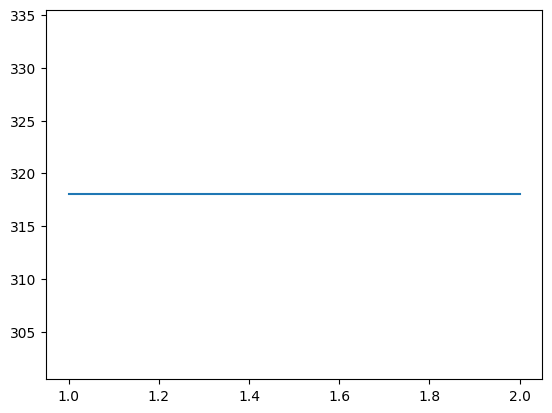

In [60]:
from tqdm import tqdm

mc = Mc2PCA(K=10, p=3, distance_metric='dtw')
cluster_indices, errors, info_by_cluster = mc.fit(reshaped_data_mc2pca)
plt.plot(errors)
plt.show()